In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)

In [2]:
import sys
import gym
import pylab
import random
import numpy as np
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

# np.random.seed(2)
# random.seed(2)

EPISODES = 10000

np.random.seed(123)
random.seed(456)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K

tf.set_random_seed(789)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)


# A2C(Advantage Actor-Critic) agent for the Cartpole
class A2CAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1
        self.action_table = [0,1,-4,4]
        self.lam = 0
        self.alpha = 0.1
        self.target_state = 11

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 1
        self.actor_lr = 0.005
        self.critic_lr = 0.005

        # create model for policy network
        self.actor = self.build_actor()        
        self.critic = self.build_critic()
        self.critic2 = self.build_critic2()

        if self.load_model:
            self.actor.load_weights("./save_model/cartpole_actor.h5")
            self.critic.load_weights("./save_model/cartpole_critic.h5")

    # approximate policy and value using Neural Network
    # actor: state is input and probability of each action is output of model
    def build_actor(self):
        actor = Sequential()
        actor.add(Dense(24, input_dim=self.state_size, activation='relu',
                        kernel_initializer='he_uniform'))
        actor.add(Dense(self.action_size, activation='softmax',
                        kernel_initializer='he_uniform'))
        #actor.summary()
        # See note regarding crossentropy in cartpole_reinforce.py
        actor.compile(loss='categorical_crossentropy',
                      optimizer=Adam(lr=self.actor_lr))
        return actor

    # critic: state is input and value of state is output of model
    def build_critic(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic
    
    def build_critic2(self):
        critic = Sequential()
        critic.add(Dense(24, input_dim=self.state_size, activation='relu',
                         kernel_initializer='he_uniform'))
        critic.add(Dense(self.value_size, activation='linear',
                         kernel_initializer='he_uniform'))
        #critic.summary()
        critic.compile(loss="mse", optimizer=Adam(lr=self.critic_lr))
        return critic
        

    # using the output of policy network, pick action stochastically
    def get_action(self, state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]
    
    def get_maxaction(self,state):
        policy = self.actor.predict(state, batch_size=1).flatten()
        return np.argmax(policy)

    # update policy network every episode
    def train_model(self, state, action, reward1,reward2, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))
        target2 = np.zeros((1, self.value_size))     

        value = self.critic.predict(state)[0]
        value2 = self.critic2.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]
        next_value2 = self.critic2.predict(next_state)[0]
        
        reward1 = reward1 + self.lam*(reward2 - self.alpha)

        if done:
            advantages[0][action] = -1*(reward1 - value)
            target[0][0] = reward1
            target2[0][0] = reward2
        else:
            advantages[0][action] = -1*(reward1 + self.discount_factor * (next_value) - value)
            target[0][0] = reward1 + self.discount_factor * next_value
            target2[0][0] = reward2 + self.discount_factor * next_value2
#             if np.where(next_state == 1.0)[1][0] == self.target_state:
#                 target2[0][0] = 0 + self.discount_factor * next_value2
#             else:
#                 target2[0][0] = np.where(next_state == 1.0)[1][0]/10 + self.discount_factor * next_value2            
            

        self.actor.fit(state, advantages, epochs=1, verbose=0)
        self.critic.fit(state, target, epochs=1, verbose=0)
        self.critic2.fit(state,target2,epochs = 1, verbose = 0)
        
        initial_state = np.zeros((1,state_size))
        initial_state[0][0] = 1
        self.lam = min(max(0,(self.lam + 0.001*(self.critic2.predict(state)[0] - self.alpha))), 10)
        #print(self.lam)
        
        
        
    
    def get_next(self,state,action):
        #print(state)
        state_index = np.where(state == 1.0)[1][0]
        next_state_index = state_index + self.action_table[action]
        next_state = np.zeros((1,self.state_size))

        if next_state_index > self.state_size-1 or next_state_index < 0:
            next_state_index = state_index
            next_state[0][next_state_index] = 1
        else:
            next_state[0][next_state_index] = 1
            
        if next_state_index == self.target_state:
#             reward = 0.0 - self.alpha # + (self.lam*(np.where(state == 1.0)[1][0]/10 - 0.5))  
            done = True
        else:
            done = False
#             reward = 1.0 + (self.lam*(np.where(next_state == 1.0)[1][0]/10 - self.alpha))   
        
        return next_state,done

    

def get_rewards(state1,state2):
    
    if state1 == 11 and state2 == 11:
        reward1 = 0.0
    else:
        reward1 = 1.0
        
    if state1 == 11 or state2 == 11:
        reward2 = 0
    elif state1 == state2:
        reward2 = 1.0
    else:
        reward2 = 0.0
    
    return reward1,reward2
    
    


if __name__ == "__main__":
    # In case of CartPole-v1, maximum length of episode is 500
    #env = gym.make('CartPole-v1')
    # get size of state and action from environment
    state_size = 16 #env.observation_space.shape[0]
    action_size = 4 #env.action_space.n
#     store_final_penalty = np.zeros((1,EPISODES))
#     average_final_count = 0
#     total_count = 10
    
    
    
    for runs in range(1):

        
    # make A2C agent
        agent1 = A2CAgent(state_size, action_size)
        agent2 = A2CAgent(state_size,action_size)

        average_penalty = 0
        total_penalty = 0
        store_penalty = np.zeros((1,EPISODES))
        
        average_lag = 0
        total_lag = 0
        store_lag = np.zeros((1,EPISODES))
        
        opt_pol_penalty = 0
        opt_pol_count = 0
        
        scores, episodes = [], []

        for i in range(1):
            done = False
            score = 0
            #state = env.reset()
            #state = np.reshape(state, [1, state_size])
            #rand_state = random.randint(0,15)
            #state = np.zeros((1,state_size))
            #state[0][rand_state] = 1
            #state = np.reshape(state, [1, state_size])

            for e in range(EPISODES):
            #state = env.reset()
                rand_state1 = random.randint(0,state_size-1)
                rand_state2 = random.randint(0,state_size-1)

                state1 = np.zeros((1,state_size))
                state2 = np.zeros((1,state_size))

                state1[0][rand_state1] = 1
                state2[0][rand_state1] = 1
                

                #state = np.reshape(state, [1, state_size])
                for time in range(10):
                # env.render()
#                     action1 = agent1.get_action(state1)
#                     action2 = agent2.get_action(state2)

                    if state1[0][11] ==1:
                        action1 = 0
                    else:
                        action1 = agent1.get_action(state1)
                    
                    if state2[0][11] == 1:
                        action2 = 0
                    else:
                        action2 = agent2.get_action(state2)

                    next_state1, done1 = agent1.get_next(state1,action1)
                    next_state2, done2 = agent2.get_next(state2,action2)

                    reward1,reward2 = get_rewards(np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])

                #reward = reward if not done else -10
                    #next_state = np.reshape(next_state, [1, state_size])
                    #if e < EPISODES/2:
                    agent1.train_model(state1, action1, reward1,reward2,next_state1, done1)
                    agent2.train_model(state2, action2, reward1,reward2,next_state2, done2)

                    print(np.where(state1 == 1.0)[1][0],np.where(state2 == 1.0)[1][0],action1,action2,np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])
                    #print(agent1.lam,agent2.lam)
                    state1 = next_state1
                    state2 = next_state2

                    average_penalty = average_penalty + reward2
                    average_lag = average_lag + reward1
                

                    if done1 and done2:

                    #print(state)
                        print("episode: {}/{}, score: {}"
                          .format(e, EPISODES, time))
                        #print(agent1.lam)
                        #print(agent2.lam)

                        break
                    #if len(agent.memory) > batch_size:
                        #agent.replay(batch_size)
                
                
                
                total_penalty = total_penalty + average_penalty        
                store_penalty[0][e] = total_penalty/(e+1) 
                print(store_penalty[0][e])
                
                total_lag = total_lag + average_lag
                store_lag[0][e] = total_lag/(e+1)
                
                if e > EPISODES - 1000:
                    opt_pol_count = opt_pol_count + 1
                    opt_pol_penalty = opt_pol_penalty + average_penalty
                
                average_penalty = 0
                average_lag = 0

                print('*******************************')
            
#             average_count = 0
#             for count in range(total_count):
#                 state1 = np.zeros((1,state_size))
#                 state2 = np.zeros((1,state_size))

#                 st = random.randint(0,state_size-1)

#                 state1[0][st] = 1
#                 state2[0][st] = 1

#                 penalty_count = 0

#                 for t in range(10):
#                     action1 = agent1.get_maxaction(state1)
#                     action2 = agent2.get_maxaction(state2)

#                     next_state1,done1 = agent1.get_next(state1,action1)
#                     next_state2,done2 = agent2.get_next(state2,action2)

#                     reward1,reward2 = get_rewards(np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])


#                     #print(np.where(state1 == 1.0)[1][0],np.where(state2 == 1.0)[1][0],action1,action2,np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])

#                     state1 = next_state1
#                     state2 = next_state2

#                     penalty_count = penalty_count + reward2

#                     if done1 and done2:
#                         #print(penalty_count)
#                         #print('****************')
#                         #print("Success")
#                         break

#                 average_count = average_count + penalty_count
#                 #print(average_count/(count+1))


#             print(runs,average_count/total_count)

                
#         store_final_penalty = store_final_penalty + store_penalty
#         average_final_count = average_final_count + (average_count/total_count)

#     print(average_final_count/100)

/home/raghuram/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


14 14 2 1 10 15
10 15 1 2 11 11
episode: 0/10000, score: 1
0.0
*******************************
13 13 2 0 9 13
9 13 1 3 10 13
10 13 0 0 10 13
10 13 2 2 6 9
6 9 2 3 2 13
2 13 2 2 2 9
2 9 2 0 2 9
2 9 1 0 3 9
3 9 1 2 4 5
4 5 0 1 4 6
0.0
*******************************
1 1 1 1 2 2
2 2 1 1 3 3
3 3 1 3 4 7
4 7 3 2 8 3
8 3 2 0 4 3
4 3 1 1 5 4
5 4 3 0 9 4
9 4 2 3 5 8
5 8 2 2 1 4
1 4 0 3 1 8
0.6666666666666666
*******************************
10 10 3 2 14 6
14 6 1 1 15 7
15 7 1 3 15 11
15 11 3 0 15 11
15 11 1 0 15 11
15 11 2 0 11 11
episode: 3/10000, score: 5
0.5
*******************************
3 3 2 2 3 3
3 3 2 2 3 3
3 3 0 2 3 3
3 3 0 0 3 3
3 3 2 0 3 3
3 3 3 2 7 3
7 3 3 0 11 3
11 3 0 1 11 4
11 4 0 2 11 0
11 0 0 0 11 0
1.4
*******************************
15 15 0 2 15 11
15 11 1 0 15 11
15 11 2 0 11 11
episode: 5/10000, score: 2
1.1666666666666667
*******************************
1 1 2 0 1 1
1 1 3 3 5 5
5 5 1 0 6 5
6 5 1 0 7 5
7 5 3 3 11 9
11 9 0 1 11 10
11 10 0 3 11 14
11 14 0 2 11 10
11 10 0 2 11

9 9 2 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 50/10000, score: 3
0.803921568627451
*******************************
15 15 2 2 11 11
episode: 51/10000, score: 0
0.7884615384615384
*******************************
5 5 1 1 6 6
6 6 1 1 7 7
7 7 3 3 11 11
episode: 52/10000, score: 2
0.8113207547169812
*******************************
15 15 2 3 11 15
11 15 0 3 11 15
11 15 0 1 11 15
11 15 0 2 11 11
episode: 53/10000, score: 3
0.7962962962962963
*******************************
12 12 3 3 12 12
12 12 1 2 13 8
13 8 0 3 13 12
13 12 1 2 14 8
14 8 3 1 14 9
14 9 1 3 15 13
15 13 2 3 11 13
11 13 0 1 11 14
11 14 0 3 11 14
11 14 0 1 11 15
0.8
*******************************
5 5 1 3 6 9
6 9 1 0 7 9
7 9 3 3 11 13
11 13 0 3 11 13
11 13 0 0 11 13
11 13 0 3 11 13
11 13 0 3 11 13
11 13 0 3 11 13
11 13 0 3 11 13
11 13 0 3 11 13
0.7857142857142857
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 56/10000, score: 2
0.8070175438596491
*******************************

11 15 0 2 11 11
episode: 110/10000, score: 3
0.6036036036036037
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 111/10000, score: 2
0.5982142857142857
*******************************
12 12 1 1 13 13
13 13 2 3 9 13
9 13 1 2 10 9
10 9 1 1 11 10
11 10 0 3 11 14
11 14 0 1 11 15
11 15 0 2 11 11
episode: 112/10000, score: 6
0.6017699115044248
*******************************
9 9 1 3 10 13
10 13 1 3 11 13
11 13 0 3 11 13
11 13 0 0 11 13
11 13 0 3 11 13
11 13 0 1 11 14
11 14 0 1 11 15
11 15 0 2 11 11
episode: 113/10000, score: 7
0.5964912280701754
*******************************
13 13 1 0 14 13
14 13 2 1 10 14
10 14 1 1 11 15
11 15 0 2 11 11
episode: 114/10000, score: 3
0.591304347826087
*******************************
11 11 0 0 11 11
episode: 115/10000, score: 0
0.5862068965517241
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 116/10000, score: 2
0.5982905982905983
*******************************
4 4 1 1 5 5
5 5 1 0 6 5
6 5 1

2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 177/10000, score: 2
0.6123595505617978
*******************************
1 1 3 3 5 5
5 5 3 3 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 178/10000, score: 3
0.6256983240223464
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 179/10000, score: 3
0.6277777777777778
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 180/10000, score: 1
0.6298342541436464
*******************************
15 15 2 2 11 11
episode: 181/10000, score: 0
0.6263736263736264
*******************************
6 6 1 1 7 7
7 7 3 3 11 11
episode: 182/10000, score: 1
0.6284153005464481
*******************************
4 4 1 1 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 183/10000, score: 3
0.6304347826086957
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 184/10000, score: 2
0.6378378378378379
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 

7 10 3 1 11 11
episode: 247/10000, score: 1
0.625
*******************************
11 11 0 0 11 11
episode: 248/10000, score: 0
0.6224899598393574
*******************************
6 6 1 1 7 7
7 7 3 3 11 11
episode: 249/10000, score: 1
0.624
*******************************
0 0 1 3 1 4
1 4 3 1 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 250/10000, score: 4
0.6254980079681275
*******************************
15 15 2 2 11 11
episode: 251/10000, score: 0
0.623015873015873
*******************************
10 10 1 1 11 11
episode: 252/10000, score: 0
0.6205533596837944
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 253/10000, score: 2
0.6220472440944882
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 254/10000, score: 2
0.6274509803921569
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 255/10000, score: 1
0.62890625
*******************************
5 5 1 3 6 9
6 9 3 1 10 10
10 10 1 1 11 11
episode: 256

9 14 1 1 10 15
10 15 1 2 11 11
episode: 318/10000, score: 3
0.6363636363636364
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 319/10000, score: 2
0.640625
*******************************
4 4 1 1 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 320/10000, score: 3
0.6417445482866043
*******************************
11 11 0 0 11 11
episode: 321/10000, score: 0
0.639751552795031
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 322/10000, score: 3
0.6408668730650154
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 323/10000, score: 1
0.6419753086419753
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 324/10000, score: 1
0.6430769230769231
*******************************
11 11 0 0 11 11
episode: 325/10000, score: 0
0.6411042944785276
*******************************
4 4 1 1 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 326/10000, score: 3
0.64220183486

0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 391/10000, score: 4
0.6301020408163265
*******************************
15 15 2 2 11 11
episode: 392/10000, score: 0
0.628498727735369
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 393/10000, score: 3
0.6294416243654822
*******************************
10 10 1 1 11 11
episode: 394/10000, score: 0
0.6278481012658228
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 395/10000, score: 1
0.6262626262626263
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 396/10000, score: 3
0.6272040302267002
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 397/10000, score: 2
0.6306532663316583
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 398/10000, score: 2
0.6290726817042607
*******************************
5 5 1 3 6 9
6 9 1 1 7

7 7 3 3 11 11
episode: 463/10000, score: 0
0.6206896551724138
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 464/10000, score: 2
0.6236559139784946
*******************************
7 7 3 3 11 11
episode: 465/10000, score: 0
0.6223175965665236
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 466/10000, score: 1
0.6209850107066381
*******************************
4 4 1 1 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 467/10000, score: 3
0.6217948717948718
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 468/10000, score: 2
0.6247334754797441
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 469/10000, score: 1
0.6234042553191489
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 470/10000, score: 2
0.6220806794055201
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 471/10000, score: 3
0.620

0.601123595505618
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 534/10000, score: 4
0.6
*******************************
11 11 0 0 11 11
episode: 535/10000, score: 0
0.5988805970149254
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 536/10000, score: 2
0.5977653631284916
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 537/10000, score: 2
0.6003717472118959
*******************************
15 15 2 2 11 11
episode: 538/10000, score: 0
0.5992578849721707
*******************************
7 7 3 3 11 11
episode: 539/10000, score: 0
0.5981481481481481
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 540/10000, score: 3
0.5988909426987061
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 541/10000, score: 1
0.5977859778597786
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 542/1000

1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 607/10000, score: 4
0.5740131578947368
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 608/10000, score: 1
0.5747126436781609
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 609/10000, score: 2
0.5737704918032787
*******************************
10 10 1 1 11 11
episode: 610/10000, score: 0
0.5728314238952537
*******************************
15 15 2 2 11 11
episode: 611/10000, score: 0
0.5718954248366013
*******************************
15 15 2 2 11 11
episode: 612/10000, score: 0
0.5709624796084829
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 613/10000, score: 1
0.5700325732899023
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 614/10000, score: 4
0.5691056910569106
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 615/10000, score: 3
0.5698051948051948
**

10 15 1 2 11 11
episode: 681/10000, score: 1
0.5527859237536656
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 682/10000, score: 3
0.5519765739385066
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 683/10000, score: 1
0.5511695906432749
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 684/10000, score: 2
0.5503649635036496
*******************************
8 8 2 1 4 9
4 9 1 1 5 10
5 10 1 1 6 11
6 11 1 0 7 11
7 11 3 0 11 11
episode: 685/10000, score: 4
0.5495626822157434
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 686/10000, score: 2
0.5502183406113537
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 687/10000, score: 3
0.5508720930232558
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 688/10000, score: 2
0.5529753265602322
*******************************
7 7 3 3 11 1

1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 754/10000, score: 3
0.5364238410596026
*******************************
10 10 1 1 11 11
episode: 755/10000, score: 0
0.5357142857142857
*******************************
13 13 2 2 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 756/10000, score: 2
0.5376486129458389
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 757/10000, score: 1
0.5382585751978892
*******************************
11 11 0 0 11 11
episode: 758/10000, score: 0
0.5375494071146245
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 759/10000, score: 3
0.5368421052631579
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 760/10000, score: 3
0.5374507227332457
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 761/10000, score: 3
0.5380577427821522
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 762/10000

15 15 2 2 11 11
episode: 826/10000, score: 0
0.535671100362757
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 827/10000, score: 2
0.5362318840579711
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 828/10000, score: 2
0.5355850422195416
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 829/10000, score: 1
0.5349397590361445
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 830/10000, score: 2
0.5342960288808665
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 831/10000, score: 3
0.5336538461538461
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 832/10000, score: 3
0.5342136854741897
*******************************
11 11 0 0 11 11
episode: 833/10000, score: 0
0.5335731414868106
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 834/10000, score: 1
0.5341317365

10 15 1 2 11 11
episode: 895/10000, score: 2
0.5357142857142857
*******************************
11 11 0 0 11 11
episode: 896/10000, score: 0
0.5351170568561873
*******************************
7 7 3 3 11 11
episode: 897/10000, score: 0
0.534521158129176
*******************************
11 11 0 0 11 11
episode: 898/10000, score: 0
0.5339265850945495
*******************************
15 15 2 2 11 11
episode: 899/10000, score: 0
0.5333333333333333
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 900/10000, score: 2
0.532741398446171
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 901/10000, score: 2
0.5332594235033259
*******************************
11 11 0 0 11 11
episode: 902/10000, score: 0
0.5326688815060908
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 903/10000, score: 1
0.5320796460176991
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 904/10000

6 6 1 3 7 10
7 10 3 1 11 11
episode: 971/10000, score: 1
0.5339506172839507
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 972/10000, score: 1
0.5344295991778006
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 973/10000, score: 1
0.5349075975359343
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 974/10000, score: 2
0.5343589743589744
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 975/10000, score: 2
0.5358606557377049
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 976/10000, score: 1
0.5363357215967247
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 977/10000, score: 2
0.5357873210633947
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 978/10000, score: 2
0.5352400408580184
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 979/10000

7 10 3 1 11 11
episode: 1045/10000, score: 3
0.5353728489483748
*******************************
1 1 0 3 1 5
1 5 3 3 5 9
5 9 1 1 6 10
6 10 1 1 7 11
7 11 3 0 11 11
episode: 1046/10000, score: 4
0.5348615090735435
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1047/10000, score: 1
0.5343511450381679
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1048/10000, score: 1
0.5347950428979981
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 1049/10000, score: 1
0.5342857142857143
*******************************
15 15 2 2 11 11
episode: 1050/10000, score: 0
0.5337773549000951
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1051/10000, score: 2
0.535171102661597
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1052/10000, score: 1
0.5356125356125356
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1053/10000, score: 2
0.5360531309297912
***

6 9 1 1 7 10
7 10 3 1 11 11
episode: 1117/10000, score: 3
0.535778175313059
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1118/10000, score: 2
0.5370866845397676
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1119/10000, score: 2
0.5375
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 1120/10000, score: 1
0.5370205173951829
*******************************
7 7 3 3 11 11
episode: 1121/10000, score: 0
0.5365418894830659
*******************************
11 11 0 0 11 11
episode: 1122/10000, score: 0
0.5360641139804097
*******************************
14 14 2 1 10 15
10 15 1 1 11 15
11 15 0 2 11 11
episode: 1123/10000, score: 2
0.5355871886120996
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1124/10000, score: 3
0.536
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1125/10000, score: 2
0.5364120781527532
*******

7 10 3 1 11 11
episode: 1190/10000, score: 4
0.5348446683459278
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1191/10000, score: 2
0.535234899328859
*******************************
7 7 3 3 11 11
episode: 1192/10000, score: 0
0.5347862531433362
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1193/10000, score: 2
0.5343383584589615
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1194/10000, score: 1
0.5347280334728034
*******************************
15 15 2 2 11 11
episode: 1195/10000, score: 0
0.5342809364548495
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1196/10000, score: 2
0.5338345864661654
*******************************
7 7 3 3 11 11
episode: 1197/10000, score: 0
0.5333889816360601
*******************************
14 14 1 1 15 15
15 15 2 2 11 11
episode: 1198/10000, score: 1
0.5337781484570475
*******************************
7 7 3 3 11 11
episode: 1199/100

5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1263/10000, score: 3
0.5308544303797469
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1264/10000, score: 3
0.5312252964426878
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1265/10000, score: 3
0.5315955766192733
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1266/10000, score: 2
0.531965272296764
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1267/10000, score: 4
0.5315457413249212
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1268/10000, score: 1
0.5319148936170213
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1269/10000, score: 2
0.531496062992126
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1270/10000, score: 1
0.5310778914240756
************************

1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1336/10000, score: 4
0.5213163799551234
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1337/10000, score: 2
0.5209267563527653
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1338/10000, score: 4
0.520537714712472
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1339/10000, score: 1
0.5208955223880597
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1340/10000, score: 1
0.5212527964205816
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1341/10000, score: 1
0.5216095380029806
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 1342/10000, score: 1
0.5212211466865228
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1343/10000, score: 2
0.5223214285714286
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 

7 10 3 1 11 11
episode: 1407/10000, score: 1
0.5255681818181818
*******************************
11 11 0 0 11 11
episode: 1408/10000, score: 0
0.525195173882186
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1409/10000, score: 3
0.524822695035461
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1410/10000, score: 2
0.5244507441530829
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 1411/10000, score: 1
0.5240793201133145
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1412/10000, score: 1
0.524416135881104
*******************************
7 7 3 3 11 11
episode: 1413/10000, score: 0
0.5240452616690241
*******************************
10 10 1 1 11 11
episode: 1414/10000, score: 0
0.5236749116607774
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1415/10000, score: 1
0.5240112994350282
*******************************
10 10 1 1 11 11
episode: 1416

10 15 1 2 11 11
episode: 1479/10000, score: 1
0.5216216216216216
*******************************
11 11 0 0 11 11
episode: 1480/10000, score: 0
0.5212694125590817
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1481/10000, score: 3
0.5215924426450742
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1482/10000, score: 4
0.5212407282535402
*******************************
7 7 3 3 11 11
episode: 1483/10000, score: 0
0.52088948787062
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1484/10000, score: 3
0.5205387205387205
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1485/10000, score: 2
0.5208613728129206
*******************************
7 7 3 3 11 11
episode: 1486/10000, score: 0
0.5205110961667787
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1487/10000, sco

9 9 1 1 10 10
10 10 1 1 11 11
episode: 1550/10000, score: 1
0.5222437137330754
*******************************
11 11 0 0 11 11
episode: 1551/10000, score: 0
0.5219072164948454
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1552/10000, score: 2
0.5215711526078558
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1553/10000, score: 4
0.5212355212355212
*******************************
10 10 1 1 11 11
episode: 1554/10000, score: 0
0.5209003215434084
*******************************
7 7 3 3 11 11
episode: 1555/10000, score: 0
0.5205655526992288
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 1556/10000, score: 1
0.5202312138728323
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1557/10000, score: 3
0.5205391527599487
*******************************
10 10 1 1 11 11
episode: 1558/10000, score: 0
0.5202052597819115
*****************

5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1619/10000, score: 3
0.5135802469135803
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 1620/10000, score: 1
0.51326341764343
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1621/10000, score: 2
0.5141800246609125
*******************************
15 15 2 2 11 11
episode: 1622/10000, score: 0
0.5138632162661737
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1623/10000, score: 2
0.5135467980295566
*******************************
15 15 2 2 11 11
episode: 1624/10000, score: 0
0.5132307692307693
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1625/10000, score: 3
0.5129151291512916
*******************************
11 11 0 0 11 11
episode: 1626/10000, score: 0
0.51259987707437
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1627/10000, score: 2
0.5135135135135135
*****

9 9 1 1 10 10
10 10 1 1 11 11
episode: 1689/10000, score: 1
0.5112426035502958
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1690/10000, score: 1
0.511531638083974
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1691/10000, score: 2
0.5112293144208038
*******************************
11 11 0 0 11 11
episode: 1692/10000, score: 0
0.5109273479031305
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1693/10000, score: 1
0.5106257378984652
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1694/10000, score: 1
0.5109144542772861
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1695/10000, score: 4
0.5106132075471698
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1696/10000, score: 3
0.5109015910430171
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1697/1

7 10 3 1 11 11
episode: 1759/10000, score: 2
0.5079545454545454
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1760/10000, score: 2
0.5082339579784213
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1761/10000, score: 4
0.5079455164585698
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1762/10000, score: 2
0.5076574021554169
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1763/10000, score: 3
0.5079365079365079
*******************************
10 10 1 1 11 11
episode: 1764/10000, score: 0
0.5076487252124646
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 1765/10000, score: 1
0.507361268403171
*******************************
15 15 2 2 11 11
episode: 1766/10000, score: 0
0.5070741369552915
*******************************
11 11 0 0 11 11
episode: 1767/10000, score: 0
0.5067873303167421
*************

1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1831/10000, score: 4
0.5027292576419214
*******************************
11 11 0 0 11 11
episode: 1832/10000, score: 0
0.502454991816694
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1833/10000, score: 3
0.5027262813522355
*******************************
7 7 3 3 11 11
episode: 1834/10000, score: 0
0.5024523160762943
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1835/10000, score: 3
0.5027233115468409
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1836/10000, score: 3
0.5029940119760479
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1837/10000, score: 4
0.5027203482045702
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1838/10000, score: 1
0.5024469820554649
*******************************
5 5 1 3 6 9
6

7 10 3 1 11 11
episode: 1902/10000, score: 3
0.49658434051497635
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1903/10000, score: 1
0.49684873949579833
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1904/10000, score: 3
0.4965879265091864
*******************************
11 11 0 0 11 11
episode: 1905/10000, score: 0
0.4963273871983211
*******************************
15 15 2 2 11 11
episode: 1906/10000, score: 0
0.4960671211326691
*******************************
11 11 0 0 11 11
episode: 1907/10000, score: 0
0.49580712788259956
*******************************
1 1 3 3 5 5
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1908/10000, score: 3
0.4960712414876899
*******************************
10 10 1 1 11 11
episode: 1909/10000, score: 0
0.49581151832460735
*******************************
15 15 2 2 11 11
episode: 1910/10000, score: 0
0.4955520669806384
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11

0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1973/10000, score: 4
0.49544072948328266
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 1974/10000, score: 1
0.4956962025316456
*******************************
10 10 1 1 11 11
episode: 1975/10000, score: 0
0.49544534412955465
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 1976/10000, score: 1
0.49570055639858374
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1977/10000, score: 2
0.4954499494438827
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 1978/10000, score: 3
0.49519959575543204
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 1979/10000, score: 2
0.494949494949495
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 1980/10000, score: 3
0.49520444220090865
*******************************
1 1 3 1 5 2
5 2 

10 10 1 1 11 11
episode: 2047/10000, score: 0
0.49267578125
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2048/10000, score: 3
0.49292337725719865
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2049/10000, score: 2
0.4926829268292683
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2050/10000, score: 3
0.4929302779132131
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2051/10000, score: 2
0.4926900584795322
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2052/10000, score: 2
0.4929371651242085
*******************************
10 10 1 1 11 11
episode: 2053/10000, score: 0
0.49269717624148
*******************************
10 10 1 1 11 11
episode: 2054/10000, score: 0
0.49245742092457423
*******************************
10 10 1 1 11 11
episode: 2055/10000, score: 0
0.49221

9 9 1 1 10 10
10 10 1 1 11 11
episode: 2119/10000, score: 1
0.4900943396226415
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2120/10000, score: 3
0.4898632720414899
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2121/10000, score: 1
0.49010367577756836
*******************************
11 11 0 0 11 11
episode: 2122/10000, score: 0
0.4898728214790391
*******************************
15 15 2 2 11 11
episode: 2123/10000, score: 0
0.4896421845574388
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2124/10000, score: 1
0.4894117647058824
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2125/10000, score: 2
0.4901222953904045
*******************************
15 15 2 2 11 11
episode: 2126/10000, score: 0
0.4898918664786084
*******************************
11 11 0 0 11 11
episode: 2127/10000, score: 0
0.48966165413533835
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2189/10000, score: 2
0.4872146118721461
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2190/10000, score: 2
0.4869922409858512
*******************************
10 10 1 1 11 11
episode: 2191/10000, score: 0
0.48677007299270075
*******************************
10 10 1 1 11 11
episode: 2192/10000, score: 0
0.48654810761513906
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2193/10000, score: 3
0.48678213309024615
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2194/10000, score: 2
0.4874715261958998
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2195/10000, score: 1
0.4872495446265938
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2196/10000, score: 3
0.48748293126991354
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 1

1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2262/10000, score: 4
0.484312859036677
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2263/10000, score: 3
0.48454063604240283
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2264/10000, score: 3
0.4847682119205298
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2265/10000, score: 2
0.4854368932038835
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2266/10000, score: 1
0.48566387295985886
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2267/10000, score: 1
0.48544973544973546
*******************************
15 15 2 2 11 11
episode: 2268/10000, score: 0
0.48523578669017187
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2269/10000, score: 2
0.48502202643171805
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
epis

4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2333/10000, score: 3
0.48500428449014565
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2334/10000, score: 2
0.484796573875803
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2335/10000, score: 2
0.4845890410958904
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2336/10000, score: 1
0.4848095849379546
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2337/10000, score: 3
0.48502994011976047
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2338/10000, score: 1
0.4848225737494656
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 2339/10000, score: 1
0.4846153846153846
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2340/10000, score: 2
0.48483554036736437
*******************************
12 12 1 1 13 13
13 13 2 

15 15 2 2 11 11
episode: 2406/10000, score: 0
0.48483589530535937
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2407/10000, score: 2
0.48546511627906974
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2408/10000, score: 1
0.48567870485678705
*******************************
10 10 1 1 11 11
episode: 2409/10000, score: 0
0.4854771784232365
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2410/10000, score: 1
0.48569058481957694
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2411/10000, score: 2
0.4854892205638474
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 2412/10000, score: 1
0.4852880232076254
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2413/10000, score: 2
0.4850869925434963
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2414/10000, score: 2
0.4857142857142857
*******************

9 14 1 1 10 15
10 15 1 2 11 11
episode: 2477/10000, score: 3
0.4858757062146893
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 2478/10000, score: 1
0.4856797095603066
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2479/10000, score: 1
0.4854838709677419
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2480/10000, score: 1
0.4856912535268037
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2481/10000, score: 3
0.4854955680902498
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2482/10000, score: 2
0.48610551751913006
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2483/10000, score: 2
0.4867149758454106
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2484/10000, score: 2
0.48732394366197185
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2

4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2549/10000, score: 3
0.4850980392156863
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2550/10000, score: 1
0.4852998823990592
*******************************
10 10 1 1 11 11
episode: 2551/10000, score: 0
0.48510971786833856
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2552/10000, score: 2
0.4849197023110067
*******************************
11 11 0 0 11 11
episode: 2553/10000, score: 0
0.48472983555207516
*******************************
11 11 0 0 11 11
episode: 2554/10000, score: 0
0.48454011741682973
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2555/10000, score: 3
0.4847417840375587
*******************************
11 11 0 0 11 11
episode: 2556/10000, score: 0
0.4845522096206492
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2557/10000, score: 2
0.48514464425332293
*************

8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2621/10000, score: 2
0.4839816933638444
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2622/10000, score: 3
0.48379717880289747
*******************************
15 15 2 2 11 11
episode: 2623/10000, score: 0
0.4836128048780488
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2624/10000, score: 4
0.48342857142857143
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2625/10000, score: 1
0.4836252856054836
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2626/10000, score: 1
0.4838218500190331
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2627/10000, score: 2
0.4840182648401826
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2628/10000, score: 2
0.48421453023963484
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 

6 6 1 3 7 10
7 10 3 1 11 11
episode: 2692/10000, score: 3
0.48124767916821387
*******************************
10 10 1 1 11 11
episode: 2693/10000, score: 0
0.48106904231625836
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2694/10000, score: 1
0.48126159554730985
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2695/10000, score: 1
0.4814540059347181
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2696/10000, score: 1
0.48164627363737483
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2697/10000, score: 3
0.48183839881393625
*******************************
15 15 2 2 11 11
episode: 2698/10000, score: 0
0.48165987402741756
*******************************
7 7 3 3 11 11
episode: 2699/10000, score: 0
0.48148148148148145
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2700/10000, score: 3
0.481673454276194
*****************

10 15 1 2 11 11
episode: 2765/10000, score: 3
0.4790310918293565
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2766/10000, score: 4
0.4788579689194073
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2767/10000, score: 2
0.47940751445086704
*******************************
10 10 1 1 11 11
episode: 2768/10000, score: 0
0.47923438064283136
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2769/10000, score: 2
0.4790613718411552
*******************************
7 7 3 3 11 11
episode: 2770/10000, score: 0
0.47888848791050165
*******************************
7 7 3 3 11 11
episode: 2771/10000, score: 0
0.4787157287157287
*******************************
15 15 2 2 11 11
episode: 2772/10000, score: 0
0.47854309412188967
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2773/10000, score: 1
0.47837058399423216
*******************************
8 8 1 1 9 9
9 9 

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2840/10000, score: 2
0.47870468145019357
*******************************
15 15 2 2 11 11
episode: 2841/10000, score: 0
0.47853624208304013
*******************************
15 15 2 2 11 11
episode: 2842/10000, score: 0
0.47836792120998944
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2843/10000, score: 1
0.4785513361462729
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2844/10000, score: 1
0.4787346221441125
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2845/10000, score: 4
0.4785664089950808
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2846/10000, score: 3
0.47874956094134175
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2847/10000, score: 1
0.4789325842696629
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2848/10000, s

12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2913/10000, score: 3
0.47803706245710365
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 2914/10000, score: 3
0.4782161234991424
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2915/10000, score: 1
0.4783950617283951
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 2916/10000, score: 3
0.478573877271169
*******************************
7 7 3 3 11 11
episode: 2917/10000, score: 0
0.47840986977381766
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2918/10000, score: 2
0.4782459746488523
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2919/10000, score: 2
0.47876712328767124
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2920/10000, score: 1
0.47894556658678533
*******************************
9 9 1 1 10 10
10 10 1 1 1

3 3 3 3 7 7
7 7 3 3 11 11
episode: 2984/10000, score: 1
0.47805695142378557
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 2985/10000, score: 2
0.47856664434025453
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2986/10000, score: 4
0.47840642785403414
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2987/10000, score: 3
0.4782463186077644
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2988/10000, score: 4
0.4780863164938106
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 2989/10000, score: 4
0.4779264214046823
*******************************
10 10 1 1 11 11
episode: 2990/10000, score: 0
0.4777666332330324
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 2991/10000, score: 1
0.47794117647058826
**************************

9 14 1 1 10 15
10 15 1 2 11 11
episode: 3054/10000, score: 3
0.47430441898527004
*******************************
7 7 3 3 11 11
episode: 3055/10000, score: 0
0.47414921465968585
*******************************
7 7 3 3 11 11
episode: 3056/10000, score: 0
0.47399411187438667
*******************************
15 15 2 2 11 11
episode: 3057/10000, score: 0
0.473839110529758
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3058/10000, score: 2
0.47368421052631576
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3059/10000, score: 2
0.47352941176470587
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3060/10000, score: 4
0.47337471414570403
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3061/10000, score: 3
0.47354670150228606
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3062/10000, score: 1

15 15 2 2 11 11
episode: 3128/10000, score: 0
0.469479066794503
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3129/10000, score: 3
0.46932907348242814
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 3130/10000, score: 2
0.46917917598211434
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3131/10000, score: 3
0.469029374201788
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3132/10000, score: 1
0.46887966804979253
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3133/10000, score: 2
0.4687300574345884
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3134/10000, score: 2
0.46858054226475276
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 3135/10000, score: 1
0.4684311224489796
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7

10 15 1 2 11 11
episode: 3199/10000, score: 2
0.46625
*******************************
11 11 0 0 11 11
episode: 3200/10000, score: 0
0.4661043423930022
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3201/10000, score: 3
0.46627108057464084
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3202/10000, score: 1
0.46643771464252265
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3203/10000, score: 1
0.46629213483146065
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3204/10000, score: 4
0.46614664586583465
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3205/10000, score: 3
0.46600124766063633
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 3206/10000, score: 2
0.46585594013096354
*******************************
7 7 3 3 11 11
episode: 3207/10000, score: 0
0.4657107

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3272/10000, score: 2
0.4634891536816376
*******************************
10 10 1 1 11 11
episode: 3273/10000, score: 0
0.46334758704948076
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3274/10000, score: 3
0.4635114503816794
*******************************
11 11 0 0 11 11
episode: 3275/10000, score: 0
0.4633699633699634
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3276/10000, score: 1
0.46353371986573083
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3277/10000, score: 2
0.46339231238560097
*******************************
7 7 3 3 11 11
episode: 3278/10000, score: 0
0.4632509911558402
*******************************
7 7 3 3 11 11
episode: 3279/10000, score: 0
0.463109756097561
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 3280/10000, score: 1
0.46296860713197197
*******************************
0 0 1 

10 15 1 2 11 11
episode: 3344/10000, score: 3
0.4615844544095665
*******************************
7 7 3 3 11 11
episode: 3345/10000, score: 0
0.46144650328750747
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 3346/10000, score: 1
0.4613086345981476
*******************************
15 15 2 2 11 11
episode: 3347/10000, score: 0
0.46117084826762245
*******************************
15 15 2 2 11 11
episode: 3348/10000, score: 0
0.46103314422215586
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3349/10000, score: 1
0.46119402985074626
*******************************
10 10 1 1 11 11
episode: 3350/10000, score: 0
0.4610564010743062
*******************************
11 11 0 0 11 11
episode: 3351/10000, score: 0
0.46091885441527447
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3352/10000, score: 3
0.46107963018192666
*******************************
10 10 1 1 11 11
episode: 3353/10000, score: 0
0

5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3417/10000, score: 3
0.4566998244587478
*******************************
7 7 3 3 11 11
episode: 3418/10000, score: 0
0.4565662474407722
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3419/10000, score: 2
0.4564327485380117
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3420/10000, score: 1
0.4565916398713826
*******************************
15 15 2 2 11 11
episode: 3421/10000, score: 0
0.45645821157218003
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 3422/10000, score: 1
0.4563248612328367
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3423/10000, score: 1
0.45619158878504673
*******************************
10 10 1 1 11 11
episode: 3424/10000, score: 0
0.45605839416058397
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 3425/10000, score: 1
0.45592527729130183
*******************************
1 1 3 1 5 2
5 2 1 3 6 6

14 14 2 1 10 15
10 15 1 2 11 11
episode: 3487/10000, score: 1
0.4561353211009174
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3488/10000, score: 1
0.45629120091716824
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3489/10000, score: 3
0.45644699140401146
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3490/10000, score: 2
0.4568891435118877
*******************************
7 7 3 3 11 11
episode: 3491/10000, score: 0
0.456758304696449
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3492/10000, score: 1
0.45691382765531063
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3493/10000, score: 2
0.4567830566685747
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3494/10000, score: 3
0.4569384835479256
*******************************
15 15 2 2 11 11
episode: 3495/10000, score: 0
0.45

7 10 3 1 11 11
episode: 3560/10000, score: 4
0.4538051109238978
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3561/10000, score: 3
0.4536777091521617
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3562/10000, score: 3
0.4535503788941903
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3563/10000, score: 2
0.45398428731762064
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3564/10000, score: 2
0.45385694249649366
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3565/10000, score: 3
0.45401009534492426
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3566/10000, score: 3
0.45388281469021585
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 3567/10000, score: 1
0.45375560538116594
*******************************
3 3 

12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3633/10000, score: 3
0.45129334067143645
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3634/10000, score: 3
0.4511691884456671
*******************************
11 11 0 0 11 11
episode: 3635/10000, score: 0
0.45104510451045104
*******************************
7 7 3 3 11 11
episode: 3636/10000, score: 0
0.45092108880945836
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3637/10000, score: 1
0.45107201759208354
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3638/10000, score: 3
0.4512228634240176
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3639/10000, score: 1
0.4510989010989011
*******************************
10 10 1 1 11 11
episode: 3640/10000, score: 0
0.45097500686624553
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3641/10000, score: 1
0.45085118066996155

4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3708/10000, score: 3
0.4480992181180911
*******************************
15 15 2 2 11 11
episode: 3709/10000, score: 0
0.44797843665768194
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3710/10000, score: 2
0.4483966585825923
*******************************
11 11 0 0 11 11
episode: 3711/10000, score: 0
0.4482758620689655
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3712/10000, score: 2
0.4481551306221384
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3713/10000, score: 3
0.44803446418955306
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 3714/10000, score: 1
0.4479138627187079
*******************************
11 11 0 0 11 11
episode: 3715/10000, score: 0
0.4477933261571582
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3716/10000, score: 1
0.44794188861985473
****

7 10 3 1 11 11
episode: 3781/10000, score: 2
0.44658910629296666
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3782/10000, score: 3
0.44673539518900346
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3783/10000, score: 1
0.4466173361522199
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 3784/10000, score: 1
0.4467635402906209
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3785/10000, score: 1
0.4466455361859482
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3786/10000, score: 2
0.4470557169263269
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 3787/10000, score: 2
0.44693769799366423
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3788/10000, score: 3
0.44681974135655844
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3

5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3853/10000, score: 3
0.44421380384016607
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3854/10000, score: 2
0.44409857328145264
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3855/10000, score: 4
0.44398340248962653
*******************************
11 11 0 0 11 11
episode: 3856/10000, score: 0
0.44386829141820067
*******************************
15 15 2 2 11 11
episode: 3857/10000, score: 0
0.44375324002073613
*******************************
7 7 3 3 11 11
episode: 3858/10000, score: 0
0.4436382482508422
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3859/10000, score: 2
0.44352331606217615
*******************************
11 11 0 0 11 11
episode: 3860/10000, score: 0
0.44340844340844343
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3861/10000, sc

9 14 1 1 10 15
10 15 1 2 11 11
episode: 3924/10000, score: 3
0.4445859872611465
*******************************
11 11 0 0 11 11
episode: 3925/10000, score: 0
0.4444727457972491
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 3926/10000, score: 1
0.44461420932009166
*******************************
11 11 0 0 11 11
episode: 3927/10000, score: 0
0.4445010183299389
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3928/10000, score: 1
0.4443878849580046
*******************************
11 11 0 0 11 11
episode: 3929/10000, score: 0
0.4442748091603053
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 3930/10000, score: 3
0.44441617908929026
*******************************
11 11 0 0 11 11
episode: 3931/10000, score: 0
0.4443031536113937
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 3932/10000, score: 2
0.4441901856089499
*******************************
7 7 3 3 11 11
epis

5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 3997/10000, score: 4
0.4447223611805903
*******************************
10 10 1 1 11 11
episode: 3998/10000, score: 0
0.4446111527881971
*******************************
10 10 1 1 11 11
episode: 3999/10000, score: 0
0.4445
*******************************
7 7 3 3 11 11
episode: 4000/10000, score: 0
0.4443889027743064
*******************************
7 7 3 3 11 11
episode: 4001/10000, score: 0
0.44427786106946526
*******************************
11 11 0 0 11 11
episode: 4002/10000, score: 0
0.4441668748438671
*******************************
11 11 0 0 11 11
episode: 4003/10000, score: 0
0.44405594405594406
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4004/10000, score: 2
0.4444444444444444
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4005/10000, score: 1
0.444583125312032
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4006/10000, score: 2
0.44497130

12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4072/10000, score: 3
0.4419346918733121
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4073/10000, score: 3
0.4420716740304369
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4074/10000, score: 1
0.4422085889570552
*******************************
11 11 0 0 11 11
episode: 4075/10000, score: 0
0.4421000981354269
*******************************
11 11 0 0 11 11
episode: 4076/10000, score: 0
0.4419916605347069
*******************************
10 10 1 1 11 11
episode: 4077/10000, score: 0
0.441883276115743
*******************************
11 11 0 0 11 11
episode: 4078/10000, score: 0
0.4417749448394214
*******************************
2 2 3 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4079/10000, score: 2
0.44191176470588234
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4080/10000, score: 2
0.44229355550110266
****************

7 10 3 1 11 11
episode: 4142/10000, score: 3
0.4433985034998793
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4143/10000, score: 2
0.4432915057915058
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4144/10000, score: 4
0.4431845597104946
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 4145/10000, score: 2
0.44307766521948866
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4146/10000, score: 3
0.44321196045333977
*******************************
7 7 3 3 11 11
episode: 4147/10000, score: 0
0.44310511089681776
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4148/10000, score: 4
0.442998312846469
*******************************
7 7 3 3 11 11
episode: 4149/10000, score: 0
0.44289156626506027
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 

14 14 2 1 10 15
10 15 1 2 11 11
episode: 4215/10000, score: 1
0.4407020872865275
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4216/10000, score: 1
0.440597581218876
*******************************
11 11 0 0 11 11
episode: 4217/10000, score: 0
0.44049312470365104
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4218/10000, score: 4
0.44038871770561744
*******************************
10 10 1 1 11 11
episode: 4219/10000, score: 0
0.44028436018957345
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4220/10000, score: 3
0.4401800521203506
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 4221/10000, score: 1
0.44007579346281384
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4222/10000, score: 3
0.4399715841818612
*******************************
11 11 0 0 11 11
episode: 4223/10000, score: 0
0.439867424

7 10 3 1 11 11
episode: 4289/10000, score: 2
0.4400932400932401
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4290/10000, score: 2
0.4399906781635982
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4291/10000, score: 3
0.44012115563839704
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4292/10000, score: 2
0.44001863498718846
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4293/10000, score: 3
0.43991616208663253
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4294/10000, score: 1
0.440046565774156
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4295/10000, score: 2
0.4399441340782123
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4296/10000, score: 2
0.4403071910635327
*******************************
14 14 2 1 10 15
10 15 1 2 1

1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4363/10000, score: 3
0.4397341888175985
*******************************
11 11 0 0 11 11
episode: 4364/10000, score: 0
0.43963344788087055
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 4365/10000, score: 1
0.4395327530920751
*******************************
7 7 3 3 11 11
episode: 4366/10000, score: 0
0.43943210441951
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4367/10000, score: 2
0.4393315018315018
*******************************
15 15 2 2 11 11
episode: 4368/10000, score: 0
0.4392309452964065
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4369/10000, score: 3
0.43935926773455375
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4370/10000, score: 3
0.43948753145733244
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4371/1

9 9 1 1 10 10
10 10 1 1 11 11
episode: 4435/10000, score: 1
0.43913435527502254
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4436/10000, score: 3
0.4392607617759748
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4437/10000, score: 2
0.439612438035151
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4438/10000, score: 1
0.4397386798828565
*******************************
7 7 3 3 11 11
episode: 4439/10000, score: 0
0.43963963963963965
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4440/10000, score: 1
0.4395406439990993
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 4441/10000, score: 1
0.4394416929311121
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4442/10000, score: 1
0.4395678595543552
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 4443/10000, score: 2
0.43946894689468946
***

6 6 1 3 7 10
7 10 3 1 11 11
episode: 4504/10000, score: 3
0.43817980022197556
*******************************
11 11 0 0 11 11
episode: 4505/10000, score: 0
0.4380825565912117
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 4506/10000, score: 2
0.43798535611271355
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4507/10000, score: 2
0.4383318544809228
*******************************
15 15 2 2 11 11
episode: 4508/10000, score: 0
0.4382346418274562
*******************************
7 7 3 3 11 11
episode: 4509/10000, score: 0
0.4381374722838137
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4510/10000, score: 1
0.43826202615827975
*******************************
10 10 1 1 11 11
episode: 4511/10000, score: 0
0.43816489361702127
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 4512/10000, score: 1
0.438067804121427
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7

6 9 1 1 7 10
7 10 3 1 11 11
episode: 4579/10000, score: 3
0.43646288209606987
*******************************
10 10 1 1 11 11
episode: 4580/10000, score: 0
0.43636760532634794
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4581/10000, score: 2
0.4362723701440419
*******************************
15 15 2 2 11 11
episode: 4582/10000, score: 0
0.4361771765219289
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4583/10000, score: 1
0.4363001745200698
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4584/10000, score: 1
0.43642311886586693
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4585/10000, score: 1
0.4365460095944178
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4586/10000, score: 1
0.4366688467407892
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 4587/10000, score: 1
0.4365736704446382
*******************************
4 4 1 3 5 8
5 8 

7 10 3 1 11 11
episode: 4652/10000, score: 1
0.43563292499462714
*******************************
11 11 0 0 11 11
episode: 4653/10000, score: 0
0.43553932101418136
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4654/10000, score: 1
0.4354457572502685
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4655/10000, score: 1
0.43556701030927836
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4656/10000, score: 3
0.43547348078161907
*******************************
15 15 2 2 11 11
episode: 4657/10000, score: 0
0.43537999141262346
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4658/10000, score: 4
0.4352865421764327
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4659/10000, score: 2
0.4351931330472103
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4660/10000, score: 2
0.43509976399914

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4727/10000, score: 3
0.4323181049069374
*******************************
11 11 0 0 11 11
episode: 4728/10000, score: 0
0.43222668640304507
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4729/10000, score: 3
0.4321353065539112
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4730/10000, score: 3
0.4322553371380258
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4731/10000, score: 2
0.43258664412510567
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4732/10000, score: 3
0.4324952461440947
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4733/10000, score: 3
0.43261512463033375
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4734/10000, score: 3
0.4327

10 10 1 1 11 11
episode: 4800/10000, score: 2
0.4330347844199125
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4801/10000, score: 2
0.4329446064139942
*******************************
15 15 2 2 11 11
episode: 4802/10000, score: 0
0.43285446595877575
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4803/10000, score: 3
0.43297252289758537
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 4804/10000, score: 2
0.4328824141519251
*******************************
7 7 3 3 11 11
episode: 4805/10000, score: 0
0.4327923429047025
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4806/10000, score: 2
0.4331183690451425
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4807/10000, score: 1
0.43302828618968386
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4808/10000, sc

10 10 1 1 11 11
episode: 4872/10000, score: 1
0.43402421506258976
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4873/10000, score: 1
0.4341403364792778
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4874/10000, score: 3
0.43425641025641026
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4875/10000, score: 3
0.43437243642329776
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4876/10000, score: 2
0.43428337092474883
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 4877/10000, score: 1
0.43419434194341944
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 4878/10000, score: 2
0.4341053494568559
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4879/10000, score: 1
0.43401639344262294
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 4945/10000, score: 3
0.4340881520420542
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4946/10000, score: 1
0.4340004042854255
*******************************
15 15 2 2 11 11
episode: 4947/10000, score: 0
0.43391269199676635
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4948/10000, score: 3
0.4340270761770055
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 4949/10000, score: 1
0.43414141414141416
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 4950/10000, score: 1
0.434053726519895
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 4951/10000, score: 2
0.43436995153473346
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 4952/10000, score: 3
0.434282253179891
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 4953/10000, 

6 6 1 3 7 10
7 10 3 1 11 11
episode: 5016/10000, score: 3
0.4339246561690253
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5017/10000, score: 3
0.43383818254284573
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5018/10000, score: 3
0.43375174337517436
*******************************
15 15 2 2 11 11
episode: 5019/10000, score: 0
0.43366533864541834
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5020/10000, score: 4
0.4335789683330014
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5021/10000, score: 3
0.4336917562724014
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5022/10000, score: 3
0.43380449930320525
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5023/10000, score: 1
0.4339171974522293
*******************************
0 0 1 

9 9 1 1 10 10
10 10 1 1 11 11
episode: 5088/10000, score: 1
0.4340734918451562
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5089/10000, score: 2
0.4343811394891945
*******************************
7 7 3 3 11 11
episode: 5090/10000, score: 0
0.43429581614614027
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5091/10000, score: 3
0.4344069128043991
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5092/10000, score: 2
0.4343216179069311
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5093/10000, score: 3
0.43443266588142915
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5094/10000, score: 3
0.43454367026496565
*******************************
11 11 0 0 11 11
episode: 5095/10000, score: 0
0.434458398744113
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5096/10

6 6 1 3 7 10
7 10 3 1 11 11
episode: 5161/10000, score: 1
0.4345215032932972
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5162/10000, score: 3
0.4346310284718187
*******************************
10 10 1 1 11 11
episode: 5163/10000, score: 0
0.4345468628969791
*******************************
10 10 1 1 11 11
episode: 5164/10000, score: 0
0.4344627299128751
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5165/10000, score: 2
0.4347657762291909
*******************************
10 10 1 1 11 11
episode: 5166/10000, score: 0
0.4346816334430037
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5167/10000, score: 1
0.43459752321981426
*******************************
10 10 1 1 11 11
episode: 5168/10000, score: 0
0.4345134455407235
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5169/10000, score: 1
0.4346228239845261
*******************************
12 12 1 1 13 13
13 13 2 1 

7 7 3 3 11 11
episode: 5235/10000, score: 1
0.4343009931245225
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5236/10000, score: 3
0.43421806377697153
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5237/10000, score: 1
0.43432607865597556
*******************************
15 15 2 2 11 11
episode: 5238/10000, score: 0
0.43424317617866004
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5239/10000, score: 4
0.43416030534351147
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5240/10000, score: 1
0.4340774661324175
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5241/10000, score: 4
0.43399465852727964
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5242/10000, score: 3
0.43391188251001334
*******************************
14 14 2 1 10 15
10 15 1 2 11 1

3 6 3 3 7 10
7 10 3 1 11 11
episode: 5310/10000, score: 2
0.4349463377894935
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5311/10000, score: 2
0.4348644578313253
*******************************
15 15 2 2 11 11
episode: 5312/10000, score: 0
0.43478260869565216
*******************************
15 15 2 2 11 11
episode: 5313/10000, score: 0
0.43470079036507336
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5314/10000, score: 2
0.43461900282220134
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5315/10000, score: 1
0.4345372460496614
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5316/10000, score: 2
0.43445552003009213
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5317/10000, score: 2
0.4347499059796916
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5318/10000, score: 2
0.43466817

9 9 1 1 10 10
10 10 1 1 11 11
episode: 5386/10000, score: 2
0.43345090031557454
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5387/10000, score: 3
0.4335560504825538
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 5388/10000, score: 1
0.43347559844126926
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5389/10000, score: 2
0.4333951762523191
*******************************
11 11 0 0 11 11
episode: 5390/10000, score: 0
0.43331478389909106
*******************************
15 15 2 2 11 11
episode: 5391/10000, score: 0
0.4332344213649852
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 5392/10000, score: 1
0.4331540886334137
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5393/10000, score: 2
0.43307378568780125
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 5394/10000, score: 2
0.432993

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5457/10000, score: 2
0.43312568706485893
*******************************
10 10 1 1 11 11
episode: 5458/10000, score: 0
0.433046345484521
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5459/10000, score: 2
0.432967032967033
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5460/10000, score: 1
0.4330708661417323
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5461/10000, score: 4
0.43299157817649214
*******************************
15 15 1 2 15 11
15 11 2 0 11 11
episode: 5462/10000, score: 1
0.43291231923851364
*******************************
7 7 3 3 11 11
episode: 5463/10000, score: 0
0.43283308931185943
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5464/10000, score: 3
0.43293687099725525
*******************************
15 15 2 2 11 11
episode: 5465/10000, score: 0
0.4

6 9 1 1 7 10
7 10 3 1 11 11
episode: 5529/10000, score: 3
0.4311030741410488
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5530/10000, score: 4
0.4310251310793708
*******************************
10 10 1 1 11 11
episode: 5531/10000, score: 0
0.4309472161966739
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5532/10000, score: 3
0.4310500632568227
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5533/10000, score: 2
0.43097217202746657
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5534/10000, score: 1
0.43107497741644085
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5535/10000, score: 1
0.4311777456647399
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5536/10000, score: 2
0.4310998735777497
*******************************
10 10 1 1 11 11
episode: 5537/10000, score: 

10 15 1 2 11 11
episode: 5598/10000, score: 1
0.4298981961064476
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5599/10000, score: 3
0.43
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5600/10000, score: 2
0.4299232279950009
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 5601/10000, score: 2
0.42984648339878617
*******************************
15 15 2 2 11 11
episode: 5602/10000, score: 0
0.42976976619668034
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5603/10000, score: 3
0.42987152034261245
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5604/10000, score: 1
0.42979482604817126
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 5605/10000, score: 2
0.4297181591152337
*******************************
7 7 3 3 11 11
episode: 5606/10000, score: 0
0.429641519529

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5670/10000, score: 2
0.42920119908305415
*******************************
7 7 3 3 11 11
episode: 5671/10000, score: 0
0.42912552891396333
*******************************
15 15 2 2 11 11
episode: 5672/10000, score: 0
0.4290498854221752
*******************************
10 10 1 1 11 11
episode: 5673/10000, score: 0
0.4289742685935848
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5674/10000, score: 3
0.4288986784140969
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5675/10000, score: 3
0.4288231148696265
*******************************
7 7 3 3 11 11
episode: 5676/10000, score: 0
0.4287475779460983
*******************************
7 7 3 3 11 11
episode: 5677/10000, score: 0
0.428672067629447
*******************************
15 15 2 2 11 11
episode: 5678/10000, score: 0
0.42859658390561717
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
epi

14 14 2 1 10 15
10 15 1 2 11 11
episode: 5744/10000, score: 1
0.4269799825935596
*******************************
10 10 1 1 11 11
episode: 5745/10000, score: 0
0.42690567351200837
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5746/10000, score: 2
0.4271793979467548
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5747/10000, score: 4
0.42710508002783576
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 5748/10000, score: 2
0.42703078796312405
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 5749/10000, score: 2
0.42695652173913046
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5750/10000, score: 1
0.4268822813423752
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5751/10000, score: 1
0.42698191933240615
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5752/10000, score: 1
0.4

7 10 3 1 11 11
episode: 5815/10000, score: 4
0.4281292984869326
*******************************
7 7 3 3 11 11
episode: 5816/10000, score: 0
0.42805569881382155
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5817/10000, score: 1
0.42815400481265037
*******************************
15 15 2 2 11 11
episode: 5818/10000, score: 0
0.42808042619006703
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 5819/10000, score: 1
0.4281786941580756
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5820/10000, score: 2
0.42810513657447175
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5821/10000, score: 3
0.4282033665407077
*******************************
15 15 2 2 11 11
episode: 5822/10000, score: 0
0.4281298299845441
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5823/10000, score: 4
0.42805631868131866
***********************

1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5888/10000, score: 3
0.4270674138223807
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5889/10000, score: 3
0.4271646859083192
*******************************
15 15 2 2 11 11
episode: 5890/10000, score: 0
0.42709217450347986
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5891/10000, score: 3
0.4270196877121521
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 5892/10000, score: 2
0.42694722552180553
*******************************
15 15 2 2 11 11
episode: 5893/10000, score: 0
0.42687478791991856
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5894/10000, score: 3
0.42697201017811703
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5895/10000, score: 1
0.4270691994572592
*******************************
9 9 1 1 10 10
10 10 1 

3 3 3 3 7 7
7 7 3 3 11 11
episode: 5957/10000, score: 1
0.4266532393420611
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 5958/10000, score: 2
0.42658164121496894
*******************************
10 10 1 1 11 11
episode: 5959/10000, score: 0
0.42651006711409395
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 5960/10000, score: 1
0.4264385170273444
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 5961/10000, score: 2
0.4267024488426702
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 5962/10000, score: 1
0.42663089049136343
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 5963/10000, score: 2
0.42655935613682094
*******************************
11 11 0 0 11 11
episode: 5964/10000, score: 0
0.426487845766974
*******************************
15 15 2 2 11 11
episode: 5965/10000, score: 0
0.42641635936976197
*******************************
14 14 2 1 1

6 9 1 1 7 10
7 10 3 1 11 11
episode: 6027/10000, score: 3
0.4263437292634373
*******************************
7 7 3 3 11 11
episode: 6028/10000, score: 0
0.42627301376679383
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6029/10000, score: 3
0.4263681592039801
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6030/10000, score: 2
0.42629746310727906
*******************************
10 10 1 1 11 11
episode: 6031/10000, score: 0
0.4262267904509284
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6032/10000, score: 1
0.426156141223272
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 6033/10000, score: 1
0.4260855154126616
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6034/10000, score: 3
0.4261806130903065
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6035/10000

5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6098/10000, score: 3
0.4244958189867191
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6099/10000, score: 3
0.4245901639344262
*******************************
11 11 0 0 11 11
episode: 6100/10000, score: 0
0.4245205703982954
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6101/10000, score: 2
0.4244509996722386
*******************************
11 11 0 0 11 11
episode: 6102/10000, score: 0
0.42438145174504344
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6103/10000, score: 3
0.424475753604194
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6104/10000, score: 4
0.4244062244062244
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6105/10000, score: 1
0.4245004913200131
*******************************
6 6 1 3 7 10
7 10 3 1 11 1

9 14 1 1 10 15
10 15 1 2 11 11
episode: 6168/10000, score: 3
0.42535256929810344
*******************************
7 7 3 3 11 11
episode: 6169/10000, score: 0
0.4252836304700162
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6170/10000, score: 2
0.42521471398476746
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6171/10000, score: 2
0.4254698639014906
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6172/10000, score: 2
0.425400939575571
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6173/10000, score: 2
0.42565597667638483
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6174/10000, score: 2
0.42591093117408907
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6175/10000, score: 4
0.4258419689119171
*******************************
7 7 3 3 11 11
episode: 6176/

7 10 3 1 11 11
episode: 6240/10000, score: 1
0.42397051754526516
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6241/10000, score: 3
0.4239025953220122
*******************************
10 10 1 1 11 11
episode: 6242/10000, score: 0
0.4238346948582412
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 6243/10000, score: 1
0.42376681614349776
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6244/10000, score: 3
0.42385908726981586
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6245/10000, score: 2
0.4241114313160423
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 6246/10000, score: 1
0.4240435408996318
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6247/10000, score: 1
0.4241357234314981
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 6248/10000, score: 2
0.

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6310/10000, score: 2
0.4235461891934717
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6311/10000, score: 1
0.4234790874524715
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 6312/10000, score: 1
0.42341200696974496
*******************************
15 15 2 2 11 11
episode: 6313/10000, score: 0
0.42334494773519166
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6314/10000, score: 3
0.4234362628661916
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6315/10000, score: 2
0.4233692210259658
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6316/10000, score: 2
0.4233022004115878
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6317/10000, score: 1
0.4233934789490345
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6318/10

7 10 3 1 11 11
episode: 6384/10000, score: 1
0.42129992169146435
*******************************
11 11 0 0 11 11
episode: 6385/10000, score: 0
0.42123394926401503
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6386/10000, score: 1
0.42132456552372005
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6387/10000, score: 1
0.42141515341264874
*******************************
7 7 3 3 11 11
episode: 6388/10000, score: 0
0.42134919392706216
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6389/10000, score: 3
0.4214397496087637
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 6390/10000, score: 2
0.4213738069159756
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6391/10000, score: 1
0.42130788485607007
*******************************
11 11 0 0 11 11
episode: 6392/10000, score: 0
0.4212419834193649
*******************************
11 11 0 0 11 11
episod

10 15 1 2 11 11
episode: 6455/10000, score: 2
0.42038413878562575
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6456/10000, score: 1
0.42047390428991793
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6457/10000, score: 1
0.4204087952926603
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6458/10000, score: 1
0.42034370645610775
*******************************
7 7 3 3 11 11
episode: 6459/10000, score: 0
0.42027863777089786
*******************************
11 11 0 0 11 11
episode: 6460/10000, score: 0
0.4202135892276737
*******************************
10 10 1 1 11 11
episode: 6461/10000, score: 0
0.4201485608170845
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6462/10000, score: 2
0.4200835525297849
*******************************
7 7 3 3 11 11
episode: 6463/10000, score: 0
0.42001856435643564
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 6464/10000, score: 1


5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6525/10000, score: 3
0.41955255899479005
*******************************
7 7 3 3 11 11
episode: 6526/10000, score: 0
0.4194882794545733
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6527/10000, score: 2
0.41942401960784315
*******************************
10 10 1 1 11 11
episode: 6528/10000, score: 0
0.41935977944555064
*******************************
7 7 3 3 11 11
episode: 6529/10000, score: 0
0.4192955589586524
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6530/10000, score: 2
0.4192313581381106
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6531/10000, score: 3
0.4191671769748928
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 6532/10000, score: 2
0.41910301545997247
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6533/10000, s

10 15 1 2 11 11
episode: 6598/10000, score: 2
0.41733595999393847
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6599/10000, score: 3
0.4174242424242424
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6600/10000, score: 4
0.41736100590819575
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6601/10000, score: 2
0.4172977885489246
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6602/10000, score: 2
0.41723459033772525
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6603/10000, score: 2
0.41747425802543914
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6604/10000, score: 4
0.4174110522331567
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 6605/10000, score: 2
0.4173478655767484
**********************

3 6 3 3 7 10
7 10 3 1 11 11
episode: 6669/10000, score: 2
0.41724137931034483
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6670/10000, score: 2
0.41717883375805725
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 6671/10000, score: 2
0.41711630695443647
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 6672/10000, score: 1
0.4170537988910535
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6673/10000, score: 1
0.4171411447407851
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6674/10000, score: 3
0.41707865168539326
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6675/10000, score: 3
0.4170161773517076
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6676/10000, score: 1
0.41695372173131645
*******************************
15 15 2 2 11 11
episode: 6677/10000, score: 0

4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6742/10000, score: 3
0.41539374165801574
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 6743/10000, score: 1
0.4153321470937129
*******************************
10 10 1 1 11 11
episode: 6744/10000, score: 0
0.41527057079318014
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6745/10000, score: 3
0.4152090127482953
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6746/10000, score: 1
0.41529568697198754
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6747/10000, score: 3
0.4152341434499111
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 6748/10000, score: 2
0.41517261816565415
*******************************
10 10 1 1 11 11
episode: 6749/10000, score: 0
0.4151111111111111
*******************************
15 15 2 2 11 11
episode: 6750/10000, score: 0
0.4150

9 9 1 1 10 10
10 10 1 1 11 11
episode: 6812/10000, score: 1
0.41523557904007047
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6813/10000, score: 1
0.41532139712356914
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6814/10000, score: 1
0.41540719002201026
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6815/10000, score: 3
0.4153462441314554
*******************************
15 15 2 2 11 11
episode: 6816/10000, score: 0
0.4152853161214611
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6817/10000, score: 2
0.41551774713992373
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6818/10000, score: 3
0.41545681184924477
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 6819/10000, score: 3
0.4155425219941349
*******************************
10 10 1 1 11 11
episode: 6820/10000, score: 0
0

5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6885/10000, score: 4
0.4150450188788847
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6886/10000, score: 2
0.41498475388412953
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6887/10000, score: 2
0.4152148664343786
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 6888/10000, score: 2
0.4151545942807374
*******************************
15 15 2 2 11 11
episode: 6889/10000, score: 0
0.41509433962264153
*******************************
10 10 1 1 11 11
episode: 6890/10000, score: 0
0.41503410245247424
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 6891/10000, score: 1
0.4149738827626233
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6892/10000, score: 4
0.41491368054548095
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episod

15 15 2 2 11 11
episode: 6960/10000, score: 0
0.4144519465594024
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 6961/10000, score: 2
0.4143924159724217
*******************************
10 10 1 1 11 11
episode: 6962/10000, score: 0
0.4143329024845612
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 6963/10000, score: 2
0.4142734060884549
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 6964/10000, score: 1
0.4143575017946877
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6965/10000, score: 3
0.4142980189491817
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 6966/10000, score: 1
0.41438208698148415
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 6967/10000, score: 3
0.4143226176808266
*******************************
10 10 1 1 11 11
episode: 6968/10000, score: 0
0.4142631654469795
**************

7 7 3 3 11 11
episode: 7034/10000, score: 1
0.4143567874911159
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 7035/10000, score: 1
0.4142978965321205
*******************************
15 15 2 2 11 11
episode: 7036/10000, score: 0
0.41423902231064375
*******************************
11 11 0 0 11 11
episode: 7037/10000, score: 0
0.414180164819551
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7038/10000, score: 1
0.41426338968603493
*******************************
7 7 3 3 11 11
episode: 7039/10000, score: 0
0.41420454545454544
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 7040/10000, score: 1
0.4141457179377929
*******************************
15 15 2 2 11 11
episode: 7041/10000, score: 0
0.41408690712865664
*******************************
10 10 1 1 11 11
episode: 7042/10000, score: 0
0.4140281130200199
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7043/10000, score: 1
0.41411130039750144
******

5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7105/10000, score: 4
0.4151421334083873
*******************************
10 10 1 1 11 11
episode: 7106/10000, score: 0
0.41508372027578444
*******************************
11 11 0 0 11 11
episode: 7107/10000, score: 0
0.41502532357906585
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7108/10000, score: 3
0.4151076100717401
*******************************
7 7 3 3 11 11
episode: 7109/10000, score: 0
0.4150492264416315
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7110/10000, score: 1
0.41513148642947545
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7111/10000, score: 3
0.4150731158605174
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7112/10000, score: 3
0.4150147617039224
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7113/10000, score: 1
0.415096991

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7178/10000, score: 3
0.41454241537818637
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7179/10000, score: 2
0.41448467966573815
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7180/10000, score: 2
0.41442696003342155
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7181/10000, score: 4
0.4143692564745196
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7182/10000, score: 4
0.41431156898231936
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7183/10000, score: 2
0.4142538975501114
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7184/10000, score: 1
0.41433542101600557
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7185/10000, score: 1
0.41441692179237405
****************************

7 10 3 1 11 11
episode: 7249/10000, score: 4
0.4129655172413793
*******************************
11 11 0 0 11 11
episode: 7250/10000, score: 0
0.4129085643359537
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7251/10000, score: 4
0.4128516271373414
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7252/10000, score: 2
0.4127947056390459
*******************************
7 7 3 3 11 11
episode: 7253/10000, score: 0
0.41273779983457404
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7254/10000, score: 1
0.4128187456926258
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7255/10000, score: 3
0.41276185226019846
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7256/10000, score: 3
0.4128427724955216
*******************************
10 10 1 1 11 11
episode: 7257/10000, score: 0
0.4127858914301

8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7324/10000, score: 2
0.41255972696245735
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7325/10000, score: 2
0.4125034125034125
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7326/10000, score: 2
0.4124471134161321
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7327/10000, score: 3
0.41239082969432317
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7328/10000, score: 2
0.412334561331696
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7329/10000, score: 1
0.41241473396998635
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7330/10000, score: 1
0.4123584776974492
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7331/10000, score: 1
0.41230223677032185
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
e

1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7395/10000, score: 4
0.4115738236884803
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7396/10000, score: 3
0.41165337298904964
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7397/10000, score: 3
0.4115977291159773
*******************************
10 10 1 1 11 11
episode: 7398/10000, score: 0
0.41154210028382215
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7399/10000, score: 3
0.41162162162162164
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7400/10000, score: 2
0.41183623834616945
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7401/10000, score: 1
0.4117805998378817
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7402/10000, score: 1
0.4118600567337566
*******************************
6 6 1 3 7 10
7

1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7466/10000, score: 4
0.4111423597160841
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7467/10000, score: 2
0.41108730583824316
*******************************
15 15 2 2 11 11
episode: 7468/10000, score: 0
0.4110322667023698
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7469/10000, score: 3
0.4111111111111111
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7470/10000, score: 1
0.4110560835229554
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7471/10000, score: 2
0.4110010706638116
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7472/10000, score: 1
0.41107988759534325
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7473/10000, score: 3
0.411024886272411
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7474/1

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7535/10000, score: 3
0.4113588110403397
*******************************
11 11 0 0 11 11
episode: 7536/10000, score: 0
0.4113042324532307
*******************************
15 15 2 2 11 11
episode: 7537/10000, score: 0
0.41124966834704163
*******************************
15 15 2 2 11 11
episode: 7538/10000, score: 0
0.41119511871601006
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7539/10000, score: 1
0.41114058355437666
*******************************
7 7 3 3 11 11
episode: 7540/10000, score: 0
0.4110860628563851
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7541/10000, score: 4
0.41103155661628216
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7542/10000, score: 1
0.41097706482831764
*******************************
7 7 3 3 11 11
episode: 7543/10000, score: 0
0.41092258748674443
*******************************
7 7 3 3 11 11
episode: 

2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7609/10000, score: 2
0.4103810775295664
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7610/10000, score: 3
0.41045854684009986
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7611/10000, score: 2
0.41040462427745666
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7612/10000, score: 1
0.41035071588073035
*******************************
11 11 0 0 11 11
episode: 7613/10000, score: 0
0.4102968216443394
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7614/10000, score: 2
0.4102429415627052
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7615/10000, score: 4
0.4101890756302521
*******************************
10 10 1 1 11 11
episode: 7616/10000, score: 0
0.4101352238414074
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10


1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7683/10000, score: 3
0.4099427381572098
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7684/10000, score: 2
0.4098893949251789
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7685/10000, score: 2
0.4098360655737705
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7686/10000, score: 2
0.4097827500975673
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 7687/10000, score: 1
0.40972944849115506
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7688/10000, score: 1
0.40980621667316947
*******************************
10 10 1 1 11 11
episode: 7689/10000, score: 0
0.40975292587776335
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7690/10000, score: 3
0.40982967104407747
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7

6 6 1 3 7 10
7 10 3 1 11 11
episode: 7754/10000, score: 1
0.40980012894906515
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7755/10000, score: 2
0.40974729241877256
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7756/10000, score: 1
0.40969446951140903
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7757/10000, score: 4
0.4096416602217066
*******************************
7 7 3 3 11 11
episode: 7758/10000, score: 0
0.4095888645444001
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7759/10000, score: 3
0.4095360824742268
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7760/10000, score: 2
0.4094833140059271
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7761/10000, score: 2
0.4096882246843597
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7762/1

0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7826/10000, score: 4
0.40960776798262427
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7827/10000, score: 1
0.40955544200306593
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7828/10000, score: 2
0.4095031293907268
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7829/10000, score: 3
0.4095785440613027
*******************************
15 15 2 2 11 11
episode: 7830/10000, score: 0
0.4095262418592772
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7831/10000, score: 3
0.40960163432073543
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 7832/10000, score: 1
0.4096770075322354
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7833/10000, score: 3
0.40975236150114885
*******************************
0 0 1 3 

7 7 3 3 11 11
episode: 7896/10000, score: 1
0.40939597315436244
*******************************
7 7 3 3 11 11
episode: 7897/10000, score: 0
0.409344137756394
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7898/10000, score: 2
0.4092923154829725
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7899/10000, score: 4
0.4092405063291139
*******************************
11 11 0 0 11 11
episode: 7900/10000, score: 0
0.4091887102898367
*******************************
10 10 1 1 11 11
episode: 7901/10000, score: 0
0.409136927360162
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7902/10000, score: 2
0.40908515753511326
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7903/10000, score: 2
0.4090334008097166
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 7904/10000, score: 3
0.40910815939278

2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7968/10000, score: 2
0.4084577738737608
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7969/10000, score: 2
0.40865746549560855
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 7970/10000, score: 4
0.40860619746581356
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7971/10000, score: 2
0.40880582037129953
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 7972/10000, score: 2
0.4087545465947573
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7973/10000, score: 3
0.4088286932530725
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 7974/10000, score: 3
0.40890282131661443
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 7975/10000, score: 1
0.4089769307923771
******************

10 10 1 1 11 11
episode: 8041/10000, score: 1
0.40885351902511813
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8042/10000, score: 1
0.40880268556508764
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8043/10000, score: 3
0.4087518647439085
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8044/10000, score: 3
0.4088253573648229
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 8045/10000, score: 2
0.40877454635843896
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8046/10000, score: 3
0.4087237479806139
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8047/10000, score: 3
0.4086729622266402
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8048/10000, score: 1
0.4087464281277177
*******************************
3 3 3 3 7 7
7 7 3 3 1

9 9 1 1 10 10
10 10 1 1 11 11
episode: 8112/10000, score: 2
0.40860347590287194
*******************************
11 11 0 0 11 11
episode: 8113/10000, score: 0
0.4085531180675376
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8114/10000, score: 3
0.4086260012322859
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8115/10000, score: 2
0.40857565303104976
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8116/10000, score: 3
0.40864851546137737
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8117/10000, score: 1
0.4085981768908598
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8118/10000, score: 4
0.40854785072053207
*******************************
7 7 3 3 11 11
episode: 8119/10000, score: 0
0.4084975369458128
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9

5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8184/10000, score: 4
0.4074526572999389
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8185/10000, score: 3
0.40752504275592477
*******************************
7 7 3 3 11 11
episode: 8186/10000, score: 0
0.4074752656650788
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8187/10000, score: 4
0.40742550073277967
*******************************
7 7 3 3 11 11
episode: 8188/10000, score: 0
0.4073757479545732
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8189/10000, score: 3
0.4073260073260073
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8190/10000, score: 3
0.4073983640581126
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8191/10000, score: 1
0.407470703125
*******************************
5 5 1 3 6 9
6 9 

9 14 1 1 10 15
10 15 1 2 11 11
episode: 8252/10000, score: 3
0.4068823458136435
*******************************
10 10 1 1 11 11
episode: 8253/10000, score: 0
0.4068330506421129
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8254/10000, score: 1
0.40678376741368866
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 8255/10000, score: 2
0.406734496124031
*******************************
10 10 1 1 11 11
episode: 8256/10000, score: 0
0.40668523676880225
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 8257/10000, score: 2
0.40663598934366674
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8258/10000, score: 2
0.40658675384429105
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 8259/10000, score: 1
0.4065375302663438
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8260/10000, score: 4
0.4064883186

14 14 2 1 10 15
10 15 1 2 11 11
episode: 8321/10000, score: 1
0.4057918769526556
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8322/10000, score: 1
0.4057431214706236
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8323/10000, score: 2
0.4056943777030274
*******************************
7 7 3 3 11 11
episode: 8324/10000, score: 0
0.40564564564564565
*******************************
10 10 1 1 11 11
episode: 8325/10000, score: 0
0.40559692529425895
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8326/10000, score: 2
0.4057883991833794
*******************************
15 15 2 2 11 11
episode: 8327/10000, score: 0
0.4057396733909702
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8328/10000, score: 1
0.4058110217313003
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 8329/10000, score: 1
0.4057623049219688
*******************************
15 15 2 2 11 11
e

9 14 1 1 10 15
10 15 1 2 11 11
episode: 8394/10000, score: 3
0.40476474091721265
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 8395/10000, score: 1
0.4047165316817532
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8396/10000, score: 1
0.4046683339287841
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8397/10000, score: 3
0.4046201476542034
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8398/10000, score: 3
0.4046910346469818
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8399/10000, score: 2
0.4048809523809524
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8400/10000, score: 1
0.4049517914533984
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8401/10000, score: 3
0.40502261366341347
*******************************
10 10 1 1 11 11
episo

6 6 1 3 7 10
7 10 3 1 11 11
episode: 8464/10000, score: 1
0.40472533963378615
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8465/10000, score: 1
0.40467753366406806
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8466/10000, score: 1
0.40462973898665405
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8467/10000, score: 3
0.40470004723665565
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8468/10000, score: 1
0.404770338882985
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8469/10000, score: 2
0.40472255017709563
*******************************
15 15 2 2 11 11
episode: 8470/10000, score: 0
0.40467477275410224
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8471/10000, score: 1
0.4047450424929179
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8472/10000, score: 1
0.40481529564498997
*****************

7 10 3 1 11 11
episode: 8536/10000, score: 4
0.404240365467963
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8537/10000, score: 2
0.40419301944249236
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8538/10000, score: 1
0.4042627942382012
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8539/10000, score: 3
0.40433255269320845
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8540/10000, score: 1
0.40440229481325374
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8541/10000, score: 3
0.404472020604074
*******************************
15 15 2 2 11 11
episode: 8542/10000, score: 0
0.40442467517265596
*******************************
15 15 2 2 11 11
episode: 8543/10000, score: 0
0.40437734082397003
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8544/10000, score: 1
0.40433001755412523
**********************

1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8607/10000, score: 3
0.40392657992565056
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8608/10000, score: 1
0.40399581832965503
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8609/10000, score: 3
0.4039488966318235
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8610/10000, score: 2
0.40390198583207526
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8611/10000, score: 2
0.4040873200185787
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8612/10000, score: 3
0.40415650760478344
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8613/10000, score: 1
0.4041095890410959
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8614/10000, score: 1
0.404178757980267
*******************************
6 6 1 3

7 7 3 3 11 11
episode: 8676/10000, score: 0
0.4040567016249856
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8677/10000, score: 1
0.4040101405853883
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8678/10000, score: 3
0.40407881092291736
*******************************
15 15 2 2 11 11
episode: 8679/10000, score: 0
0.40403225806451615
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8680/10000, score: 2
0.4039857159313443
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8681/10000, score: 3
0.4039391845196959
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8682/10000, score: 2
0.40389266382586664
*******************************
11 11 0 0 11 11
episode: 8683/10000, score: 0
0.40384615384615385
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8684/10000, score: 1
0.40391479562464017
**

5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8748/10000, score: 3
0.4042747742599154
*******************************
11 11 0 0 11 11
episode: 8749/10000, score: 0
0.40422857142857144
*******************************
7 7 3 3 11 11
episode: 8750/10000, score: 0
0.4041823791566678
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8751/10000, score: 1
0.404136197440585
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8752/10000, score: 1
0.40420427282074717
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8753/10000, score: 2
0.40415809915467216
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 8754/10000, score: 1
0.40411193603655055
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8755/10000, score: 3
0.40417999086340795
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8756/10000, score: 2
0.4041338357885120

7 10 3 1 11 11
episode: 8820/10000, score: 1
0.4044892869289196
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 8821/10000, score: 1
0.4044434368623895
*******************************
7 7 3 3 11 11
episode: 8822/10000, score: 0
0.4043975971891647
*******************************
7 7 3 3 11 11
episode: 8823/10000, score: 0
0.4043517679057117
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 8824/10000, score: 1
0.40441926345609064
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8825/10000, score: 3
0.4044867437117607
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8826/10000, score: 2
0.40444091990483744
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8827/10000, score: 2
0.40439510647938376
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8828/10000, score: 1
0.40434930343187225
**********************

7 10 3 1 11 11
episode: 8893/10000, score: 2
0.4039802113784574
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8894/10000, score: 2
0.4039347948285554
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 8895/10000, score: 3
0.4040017985611511
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8896/10000, score: 1
0.4040687872316511
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8897/10000, score: 3
0.40402337603955946
*******************************
11 11 0 0 11 11
episode: 8898/10000, score: 0
0.4039779750533768
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8899/10000, score: 2
0.40393258426966294
*******************************
11 11 0 0 11 11
episode: 8900/10000, score: 0
0.4038872036849792
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8901/1

6 9 1 1 7 10
7 10 3 1 11 11
episode: 8962/10000, score: 4
0.4038826285841794
*******************************
11 11 0 0 11 11
episode: 8963/10000, score: 0
0.4038375725122713
*******************************
11 11 0 0 11 11
episode: 8964/10000, score: 0
0.403792526491913
*******************************
7 7 3 3 11 11
episode: 8965/10000, score: 0
0.40374749051974124
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 8966/10000, score: 3
0.40381398461023754
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 8967/10000, score: 2
0.40376895628902765
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 8968/10000, score: 1
0.4037239380086966
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8969/10000, score: 2
0.40390189520624303
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 8970/10000, score: 1
0.4039683424367406
********************

5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9037/10000, score: 3
0.40385040938260675
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9038/10000, score: 2
0.40380573072242504
*******************************
11 11 0 0 11 11
episode: 9039/10000, score: 0
0.40376106194690264
*******************************
15 15 2 2 11 11
episode: 9040/10000, score: 0
0.40371640305275963
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9041/10000, score: 1
0.4037823490378235
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 9042/10000, score: 1
0.40373769766670353
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9043/10000, score: 2
0.40369305616983636
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9044/10000, score: 2
0.40364842454394695
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9045/10000, sc

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9110/10000, score: 3
0.40357809241576115
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9111/10000, score: 3
0.4036435469710272
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9112/10000, score: 3
0.4037089871611983
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9113/10000, score: 3
0.40377441299100286
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9114/10000, score: 3
0.4038398244651673
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 9115/10000, score: 1
0.4037955243527863
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9116/10000, score: 4
0.403751233958539
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episod

10 10 1 1 11 11
episode: 9180/10000, score: 0
0.4039864938459863
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 9181/10000, score: 2
0.4039424961881943
*******************************
7 7 3 3 11 11
episode: 9182/10000, score: 0
0.4038985081128172
*******************************
7 7 3 3 11 11
episode: 9183/10000, score: 0
0.40385452961672474
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9184/10000, score: 3
0.40391943385955364
*******************************
11 11 0 0 11 11
episode: 9185/10000, score: 0
0.40387546266057045
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9186/10000, score: 2
0.4038315010340699
*******************************
11 11 0 0 11 11
episode: 9187/10000, score: 0
0.4037875489769264
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9188/10000, score: 3
0.40385243225595824
*******************

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9252/10000, score: 2
0.40343672322490004
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 9253/10000, score: 2
0.4033931272963043
*******************************
15 15 2 2 11 11
episode: 9254/10000, score: 0
0.40334954078876284
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9255/10000, score: 3
0.4034140017286085
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9256/10000, score: 1
0.4033704223830615
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9257/10000, score: 1
0.40332685245193345
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 9258/10000, score: 2
0.4032832919321741
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9259/10000, score: 3
0.4033477321814255
*******************************
0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6

2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 9325/10000, score: 2
0.4030666952605619
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9326/10000, score: 3
0.40302348021871987
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9327/10000, score: 3
0.4029802744425386
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9328/10000, score: 2
0.4029370779290385
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9329/10000, score: 3
0.4028938906752412
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9330/10000, score: 3
0.4029578823277248
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9331/10000, score: 3
0.40302186026575226
*******************************
10 10 1 1 11 11
episode: 9332/10000, score: 0
0.4029786778099218
**************************

6 9 1 1 7 10
7 10 3 1 11 11
episode: 9398/10000, score: 2
0.4022768379614853
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9399/10000, score: 2
0.4024468085106383
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9400/10000, score: 1
0.40240399957451334
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9401/10000, score: 2
0.40236119974473517
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9402/10000, score: 2
0.4023184090183984
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9403/10000, score: 2
0.40227562739259887
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9404/10000, score: 3
0.4023391812865497
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9405/10000, score: 1
0.4022964065490113
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9406

7 10 3 1 11 11
episode: 9468/10000, score: 2
0.40194318301827014
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9469/10000, score: 3
0.4020063357972545
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 9470/10000, score: 1
0.4019638897687678
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9471/10000, score: 1
0.40202702702702703
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9472/10000, score: 1
0.40198458777578383
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9473/10000, score: 1
0.4020477095207938
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9474/10000, score: 1
0.4021108179419525
*******************************
7 7 3 3 11 11
episode: 9475/10000, score: 0
0.4020683832840861
*******************************
15 15 2 2 11 11
episode: 9476/10000, score: 0
0.40202595758151316
*******************************
12 12 1 1 13 13
13 13 2 1 9 

7 7 3 3 11 11
episode: 9539/10000, score: 0
0.4023060796645702
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9540/10000, score: 2
0.4022639136358872
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9541/10000, score: 3
0.4022217564451897
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9542/10000, score: 3
0.40228439694016555
*******************************
10 10 1 1 11 11
episode: 9543/10000, score: 0
0.4022422464375524
*******************************
7 7 3 3 11 11
episode: 9544/10000, score: 0
0.40220010476689366
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9545/10000, score: 1
0.4022627278441232
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9546/10000, score: 1
0.40232533780245106
*******************************
7 7 3 3 11 11
episode: 9547/10000, score: 0
0.40228320067029744
*******************************
11 11 0 0

7 7 3 3 11 11
episode: 9614/10000, score: 0
0.40176807072282894
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9615/10000, score: 3
0.4018302828618968
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 9616/10000, score: 1
0.4017884995320786
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9617/10000, score: 2
0.4017467248908297
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9618/10000, score: 2
0.4017049589354403
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9619/10000, score: 1
0.4016632016632017
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9620/10000, score: 1
0.4017253923708554
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9621/10000, score: 2
0.4016836416545417
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9622/10000, score: 1
0

13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9685/10000, score: 2
0.4016105719595292
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9686/10000, score: 1
0.40167234437906474
*******************************
10 10 1 1 11 11
episode: 9687/10000, score: 0
0.40163088356729976
*******************************
11 11 0 0 11 11
episode: 9688/10000, score: 0
0.4015894313138611
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9689/10000, score: 2
0.40154798761609906
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 9690/10000, score: 2
0.4015065524713652
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9691/10000, score: 1
0.40156830375567476
*******************************
10 10 1 1 11 11
episode: 9692/10000, score: 0
0.40152687506447954
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9693/10000, score: 1
0.40158861151227565
*******************************
0

3 6 3 3 7 10
7 10 3 1 11 11
episode: 9755/10000, score: 2
0.40129151291512916
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9756/10000, score: 2
0.4012503843394486
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9757/10000, score: 3
0.4013117442098791
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 9758/10000, score: 1
0.401270621989958
*******************************
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9759/10000, score: 1
0.4012295081967213
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9760/10000, score: 3
0.4011884028275791
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9761/10000, score: 2
0.40114730587994263
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9762/10000, score: 2
0.401106217351224
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode:

7 10 3 1 11 11
episode: 9827/10000, score: 3
0.4010989010989011
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9828/10000, score: 3
0.4011598331468105
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9829/10000, score: 2
0.40111902339776195
*******************************
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9830/10000, score: 1
0.40117994100294985
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9831/10000, score: 2
0.4011391375101709
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9832/10000, score: 3
0.4010983423166887
*******************************
3 3 3 3 7 7
7 7 3 3 11 11
episode: 9833/10000, score: 1
0.40115924344112264
*******************************
4 4 1 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9834/10000, score: 3
0.40111845449923744
*******************************
0 0 1 3 1 4
1 4 3 3

0 0 1 3 1 4
1 4 3 3 5 8
5 8 1 1 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9897/10000, score: 4
0.4013942210547585
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9898/10000, score: 2
0.4013536720880897
*******************************
8 8 1 1 9 9
9 9 1 1 10 10
10 10 1 1 11 11
episode: 9899/10000, score: 2
0.4015151515151515
*******************************
2 2 1 3 3 6
3 6 3 3 7 10
7 10 3 1 11 11
episode: 9900/10000, score: 2
0.40147459852540146
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9901/10000, score: 2
0.4014340537265199
*******************************
7 7 3 3 11 11
episode: 9902/10000, score: 0
0.40139351711602544
*******************************
10 10 1 1 11 11
episode: 9903/10000, score: 0
0.4013529886914378
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9904/10000, score: 3
0.40141342756183745
*******************************
14 14 2 1 10 15
10 15 1 2 11 11

6 6 1 3 7 10
7 10 3 1 11 11
episode: 9971/10000, score: 1
0.4007220216606498
*******************************
1 1 3 1 5 2
5 2 1 3 6 6
6 6 1 3 7 10
7 10 3 1 11 11
episode: 9972/10000, score: 3
0.4007821117015943
*******************************
14 14 2 1 10 15
10 15 1 2 11 11
episode: 9973/10000, score: 1
0.40074192901544015
*******************************
5 5 1 3 6 9
6 9 1 1 7 10
7 10 3 1 11 11
episode: 9974/10000, score: 2
0.4007017543859649
*******************************
15 15 2 2 11 11
episode: 9975/10000, score: 0
0.4006615878107458
*******************************
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9976/10000, score: 2
0.40062142928736094
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9977/10000, score: 3
0.4006814992984566
*******************************
12 12 1 1 13 13
13 13 2 1 9 14
9 14 1 1 10 15
10 15 1 2 11 11
episode: 9978/10000, score: 3
0.40074155727026756
*******************************
1 1 3 1 5 2

In [7]:
np.random.seed(99)
random.seed(999)

average_count = 0
total_count = 10000
for count in range(total_count):
    state1 = np.zeros((1,state_size))
    state2 = np.zeros((1,state_size))
    
    st = random.randint(0,state_size-1)
    
    state1[0][st] = 1
    state2[0][st] = 1
    
    penalty_count = 0
    
    for t in range(10):
        action1 = agent1.get_maxaction(state1)
        action2 = agent2.get_maxaction(state2)
        
        next_state1,done1 = agent1.get_next(state1,action1)
        next_state2,done2 = agent2.get_next(state2,action2)
        
        reward1,reward2 = get_rewards(np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])


        #print(np.where(state1 == 1.0)[1][0],np.where(state2 == 1.0)[1][0],action1,action2,np.where(next_state1 == 1.0)[1][0],np.where(next_state2 == 1.0)[1][0])

        state1 = next_state1
        state2 = next_state2
        
        penalty_count = penalty_count + reward2
        
        if done1 and done2:
            #print(penalty_count)
            #print('****************')
            #print("Success")
            break
    
    average_count = average_count + penalty_count
    print(average_count/(count+1))
    
    
print(average_count/total_count)


0.0
0.0
0.0
0.0
0.0
0.16666666666666666
0.14285714285714285
0.125
0.3333333333333333
0.4
0.5454545454545454
0.5833333333333334
0.5384615384615384
0.5714285714285714
0.5333333333333333
0.625
0.5882352941176471
0.5555555555555556
0.5263157894736842
0.5
0.47619047619047616
0.45454545454545453
0.43478260869565216
0.4166666666666667
0.4
0.38461538461538464
0.37037037037037035
0.35714285714285715
0.3448275862068966
0.36666666666666664
0.3548387096774194
0.375
0.36363636363636365
0.38235294117647056
0.42857142857142855
0.4166666666666667
0.43243243243243246
0.42105263157894735
0.41025641025641024
0.425
0.4146341463414634
0.40476190476190477
0.3953488372093023
0.38636363636363635
0.4
0.41304347826086957
0.40425531914893614
0.3958333333333333
0.40816326530612246
0.4
0.39215686274509803
0.38461538461538464
0.37735849056603776
0.37037037037037035
0.38181818181818183
0.39285714285714285
0.38596491228070173
0.3793103448275862
0.3898305084745763
0.4
0.4098360655737705
0.43548387096774194
0.444444444

0.4259634888438134
0.4271255060728745
0.4262626262626263
0.4254032258064516
0.42655935613682094
0.42570281124497994
0.4248496993987976
0.424
0.4231536926147705
0.4243027888446215
0.4234592445328032
0.4226190476190476
0.42178217821782177
0.42292490118577075
0.42209072978303747
0.4251968503937008
0.4243614931237721
0.42549019607843136
0.42661448140900193
0.42578125
0.4249512670565302
0.42412451361867703
0.42524271844660194
0.4263565891472868
0.4274661508704062
0.42857142857142855
0.4296724470134875
0.4288461538461538
0.42802303262955854
0.4272030651340996
0.42638623326959846
0.4255725190839695
0.4247619047619048
0.42395437262357416
0.42314990512333966
0.42234848484848486
0.4215500945179584
0.4207547169811321
0.4199623352165725
0.4191729323308271
0.4202626641651032
0.41947565543071164
0.41869158878504675
0.417910447761194
0.41899441340782123
0.41821561338289964
0.4174397031539889
0.4185185185185185
0.4177449168207024
0.41697416974169743
0.4162062615101289
0.41544117647058826
0.41651376146

0.4075268817204301
0.4070891514500537
0.40772532188841204
0.40728831725616294
0.4068522483940043
0.40641711229946526
0.405982905982906
0.4055496264674493
0.4051172707889126
0.40468583599574015
0.4053191489361702
0.4059511158342189
0.40764331210191085
0.40721102863202546
0.4067796610169492
0.4084656084656085
0.4090909090909091
0.40865892291446676
0.40822784810126583
0.4077976817702845
0.4073684210526316
0.4069400630914827
0.40756302521008403
0.40713536201469047
0.40670859538784065
0.406282722513089
0.40690376569037656
0.40856844305120166
0.4102296450939457
0.4098018769551616
0.409375
0.4099895941727367
0.41164241164241167
0.411214953271028
0.4107883817427386
0.41036269430051814
0.4109730848861284
0.4105480868665977
0.41012396694214875
0.40970072239422084
0.41030927835051545
0.4098867147270855
0.4094650205761317
0.41109969167523125
0.4106776180698152
0.41025641025641024
0.4098360655737705
0.4104401228249744
0.4100204498977505
0.40960163432073543
0.4091836734693878
0.40978593272171254
0.4

0.42027920646583394
0.4199706314243759
0.41966250917094644
0.42008797653958946
0.4197802197802198
0.42020497803806733
0.42062911485003657
0.4203216374269006
0.4200146092037984
0.4197080291970803
0.4194018964259664
0.4205539358600583
0.4202476329206118
0.41994177583697234
0.4203636363636364
0.42078488372093026
0.420479302832244
0.42017416545718433
0.41986947063089197
0.41956521739130437
0.41926140477914553
0.4196816208393632
0.4193781634128706
0.4190751445086705
0.4187725631768953
0.4184704184704185
0.41888968997837056
0.420028818443804
0.4197264218862491
0.41942446043165466
0.41912293314162474
0.4188218390804598
0.41852117731514715
0.4182209469153515
0.41792114695340504
0.417621776504298
0.41732283464566927
0.41702432045779686
0.4174410293066476
0.4185714285714286
0.4189864382583869
0.4186875891583452
0.4183891660727014
0.4180911680911681
0.41779359430604984
0.4182076813655761
0.4186211798152097
0.4197443181818182
0.41944641589779985
0.41914893617021276
0.41885187810063784
0.4185552407

0.41065482796892344
0.4104270660011093
0.41019955654101997
0.4110803324099723
0.41140642303433
0.4111787493082457
0.41095132743362833
0.4107241569928137
0.41049723756906076
0.4102705687465489
0.41004415011037526
0.40981798124655267
0.40959206174200663
0.409366391184573
0.4091409691629956
0.40946615299944966
0.40924092409240925
0.4090159428257284
0.4087912087912088
0.40911587040087866
0.4088913282107574
0.4086670323642348
0.40899122807017546
0.40876712328767123
0.4085432639649507
0.4088669950738916
0.4086433260393873
0.4084199015855659
0.4081967213114754
0.4079737848170399
0.4077510917030568
0.408619749045281
0.4089422028353326
0.4087193460490463
0.4084967320261438
0.40827436037016873
0.40805223068552776
0.4078303425774878
0.4076086956521739
0.4084736556219446
0.40825190010857765
0.40803038524145413
0.4078091106290672
0.4075880758807588
0.40736728060671723
0.4071467244179751
0.4074675324675325
0.40724716062736616
0.40702702702702703
0.406807131280389
0.4065874730021598
0.406907717215326

0.40418894830659535
0.40400890868596884
0.40382902938557436
0.40364931019136624
0.40346975088967973
0.40373499333036905
0.40444444444444444
0.4042647712127943
0.40408525754884544
0.40390590324012426
0.404170363797693
0.4039911308203991
0.40381205673758863
0.40407620735489586
0.40434012400354297
0.4041611332447986
0.40486725663716816
0.40468819106590004
0.40450928381962864
0.40433053468846664
0.4041519434628975
0.40397350993377484
0.4042365401588703
0.40405822673136305
0.404320987654321
0.40458351696782724
0.40440528634361234
0.404227212681638
0.4040492957746479
0.4043114826220853
0.40413368513632364
0.4043956043956044
0.4046572934973638
0.4044795783926219
0.4043020193151888
0.4041246160596753
0.4043859649122807
0.40420868040333185
0.4040315512708151
0.4038545773105563
0.404553415061296
0.4048140043763676
0.40507436570428695
0.4053344993441189
0.40515734265734266
0.40498034076015726
0.40480349344978167
0.40462680052378874
0.4048865619546248
0.404709986916703
0.4045335658238884
0.4052287

0.39563286454478164
0.3958564557898631
0.39571005917159763
0.3955637707948244
0.3954175905395418
0.3952715182859254
0.39549483013293946
0.39571797711332596
0.3959409594095941
0.39579490962744374
0.39601769911504425
0.39587172871360116
0.39572586588061903
0.39558011049723757
0.3954344624447717
0.3952889216047111
0.39514348785871967
0.3949981610886355
0.3952205882352941
0.3954428518926865
0.3952975753122704
0.39515240543518176
0.39537444933920707
0.39559633027522934
0.3954512105649303
0.3953061972863953
0.3951612903225806
0.39538292414803955
0.3952380952380952
0.3954595386305383
0.39568081991215226
0.39590193926088546
0.39575713240673005
0.3956124314442413
0.3958333333333333
0.39605407380343444
0.39590942293645
0.39576487769258856
0.395985401459854
0.39584093396570597
0.39569657184536833
0.3955523149835946
0.39577259475218657
0.3963570127504554
0.3965768390386016
0.39643247178740443
0.3962882096069869
0.39614405238268463
0.39636363636363636
0.39621955652490004
0.3960755813953488
0.395931

0.39217557251908397
0.39236883942766293
0.3925619834710744
0.3924372418176041
0.3923125794155019
0.3921879961892664
0.39206349206349206
0.39193906696286895
0.39213197969543145
0.39200761179828736
0.3918833227647432
0.3917591125198098
0.3916349809885932
0.39151092809629395
0.3917036098796707
0.39157961380183604
0.3914556962025316
0.3913318570072762
0.3912080961416825
0.39108441353145745
0.390960809102402
0.3911532385466035
0.3910296904611497
0.39090622039785283
0.3907828282828283
0.3906595140422846
0.3905362776025237
0.39041311888994007
0.39029003783102145
0.39016703435234795
0.39004410838059234
0.39023622047244094
0.39011335012594456
0.3899905571293673
0.39018250471994964
0.390059767222397
0.389937106918239
0.3898145237346746
0.39000628535512255
0.38988375746151427
0.3900753768844221
0.3899529042386185
0.3898305084745763
0.39033573893944146
0.39021329987452946
0.3900909375979931
0.390282131661442
0.39047320589157003
0.39035087719298245
0.3902286251174444
0.39010644959298685
0.390297339

0.38594053903862185
0.3858333333333333
0.3857261871702305
0.38617434758467517
0.3860671662503469
0.38596004439511655
0.386130374479889
0.3863006100942873
0.38647075131688385
0.38636363636363635
0.3865336658354115
0.38698060941828255
0.38687344225976183
0.38676633444075303
0.3866592859119845
0.38682899833978973
0.3867219917012448
0.3866150442477876
0.386508155930329
0.38667772249861804
0.38657087593257805
0.38646408839779006
0.3863573598453466
0.38625069022639424
0.3861440794921336
0.38631346578366443
0.38620689655172413
0.3866519580805295
0.38654535428728976
0.3867144432194046
0.38660788095894183
0.3867768595041322
0.38694574497383644
0.38683920704845814
0.3867327277731902
0.38662630709961476
0.38651994497936726
0.3864136413641364
0.386307396205664
0.38647608576140735
0.3863698818356691
0.38653846153846155
0.3867069486404834
0.38660076880834704
0.3870436453472413
0.387211855104281
0.3871056241426612
0.38699945145364784
0.3868933369893063
0.3867872807017544
0.38668128254316253
0.3865753

0.3862682143739195
0.3861728395061728
0.38657121698346086
0.38672260612043435
0.386627189735998
0.38702516033547113
0.3869297163995068
0.3868343195266272
0.38673896968203103
0.3866436668309512
0.38654841093865483
0.38645320197044336
0.3863580398916523
0.3862629246676514
0.38641397981786857
0.38631889763779526
0.3862238622386224
0.38612887358583375
0.38603393164494715
0.3859390363815143
0.38584418776112067
0.3857493857493858
0.3856546303119627
0.38605108055009824
0.3859562975693592
0.3858615611192931
0.3857668711656442
0.3856722276741904
0.3855776306107432
0.3854830799411476
0.3856337337582741
0.38553921568627453
0.385689781916197
0.3855952964233219
0.3855008572128337
0.3856513222331048
0.38555691554467564
0.3854625550660793
0.38536824076339615
0.3852739726027397
0.38517975055025677
0.38508557457212717
0.3849914446345637
0.3848973607038123
0.384803322746152
0.38519785051294575
0.38534798534798537
0.38525390625
0.38540395411276546
0.38530990727183995
0.38545986826055134
0.385365853658536

0.3845640569395018
0.38447854124972203
0.38461538461538464
0.3845298955323405
0.3844444444444444
0.3845812041768496
0.38449577965348736
0.3844103930712858
0.38432504440497334
0.38423973362930075
0.3843763870395029
0.3845129798091857
0.38442768411712513
0.38434242625859394
0.38425720620842574
0.38417202394147637
0.3840868794326241
0.3844449368491026
0.38435976960567125
0.3842746400885936
0.38441098317094774
0.38454726588443655
0.3844621513944223
0.3845983624695729
0.3845132743362832
0.38464941384649415
0.3845643520566121
0.38492151227061683
0.3848364279398762
0.3847513812154696
0.3846663720724702
0.38458140048597306
0.3847173144876325
0.38463236917641863
0.3845474613686534
0.38446259103950564
0.3843777581641659
0.38451356717405694
0.3844287604764005
0.38434399117971335
0.38425925925925924
0.384174564690324
0.3840899074482151
0.38422560035250053
0.3843612334801762
0.38427659105923806
0.38419198590929104
0.38410741800572307
0.3840228873239437
0.38393839383938394
0.3838539375274967
0.38376

0.38731825525040386
0.3872400565313951
0.387363746467501
0.3874873864783047
0.387409200968523
0.38733104700423643
0.38765631302944736
0.3875781407541843
0.3875
0.3874218907478331
0.3873438129786376
0.387265766673383
0.38738920225624496
0.38731117824773414
0.38723318566250503
0.3871552244815784
0.38707729468599034
0.38699939625679214
0.3871227364185111
0.3870448601890968
0.38696701528559935
0.387090287552785
0.38721351025331724
0.3871356783919598
0.3872588424437299
0.3873819570022102
0.3873041382081157
0.387427194215706
0.38734939759036147
0.38747239510138526
0.3875953432356483
0.3877182420228778
0.38764044943820225
0.3875626880641926
0.38748495788206977
0.3876077802285943
0.3875300721732157
0.38745239526959313
0.387374749498998
0.3872971348427169
0.38721955128205127
0.3871419987983176
0.3872647176611934
0.3875875875875876
0.3875100080064051
0.3874324594756854
0.3873549419767907
0.3874774954990998
0.3876
0.3877224555088982
0.3876449420231907
0.38756745952428545
0.3876898481215028
0.3878

0.3814814814814815
0.38141084984262175
0.381340244353943
0.38145474736257634
0.3813841598815692
0.381313598519889
0.3812430632630411
0.3811725540965415
0.38110207100591714
0.3810316139767055
0.3809611829944547
0.3808907780447237
0.380820399113082
0.3809347866247922
0.3810491318803103
0.3809787626962142
0.38090841949778437
0.3808381022706295
0.38095238095238093
0.38088208156486436
0.38099630996309963
0.38111049621840987
0.38104020656584286
0.3809699428360686
0.3808997050147493
0.3808294930875576
0.3807593070401769
0.3810576745900129
0.38098747236551217
0.38091729600294716
0.38084714548802945
0.3807770208064813
0.3807069219440353
0.38063684888643473
0.38075082811924915
0.38086476540938363
0.38079470198675497
0.3807246643369505
0.38065465244575214
0.380584666298952
0.3805147058823529
0.38044477118176806
0.38037486218302097
0.38030497887194564
0.38023512123438646
0.38016528925619836
0.3800954829232464
0.3800257022214063
0.3799559471365639
0.38006973756652596
0.3801834862385321
0.3801137405

0.3783459162663006
0.37828100874935666
0.3783876500857633
0.37832275767449836
0.3782578875171468
0.37819303960226297
0.37812821391840934
0.37823479005998284
0.3781699794379712
0.37810519102278567
0.37821171634121276
0.3781469429696866
0.3780821917808219
0.37818866632425957
0.3781239301609038
0.3782303611158651
0.37833675564681724
0.37827202737382376
0.37820732124529594
0.37814263724987174
0.378077975376197
0.3781843050094033
0.37811965811965814
0.3780550333276363
0.3783321941216678
0.3786092602084401
0.37871540826785105
0.3786507258753202
0.3785860655737705
0.37852142735188665
0.3784568111983612
0.37856289469192694
0.37866894197952217
0.37877495307967923
0.37871033776867963
0.378645744499403
0.378581173260573
0.3788576300085251
0.37879304466416636
0.3787284813362877
0.37866394001363324
0.37859942068495483
0.37853492333901195
0.37847044796457163
0.37840599455040874
0.37834156308530564
0.3782771535580524
0.3782127659574468
0.37831858407079644
0.3782542113323124
0.3781898604967676
0.37829

0.3788987905792489
0.3788385043754972
0.37893732103086225
0.3790361062509941
0.37897582697201015
0.3789155668627763
0.37901430842607314
0.3789540613574948
0.378893833439288
0.37883362466232323
0.37877343501747696
0.3787132644956315
0.3786531130876747
0.37859298078450054
0.37853286757700855
0.37847277345610414
0.3784126984126984
0.3783526424377083
0.3782926055220565
0.37823258765667145
0.3783312182741117
0.3784298176050753
0.3783698065334602
0.37846836847946724
0.37840837032339886
0.3783483911871929
0.37828843106180665
0.3782284899382031
0.3784854245880862
0.37842547124980197
0.37852391510928096
0.37878068091844813
0.3790373654211526
0.3791356656640811
0.37907565685343464
0.37901566703592343
0.37895569620253167
0.37889574434424933
0.3788358114520721
0.37893405029258265
0.3790322580645161
0.37897233201581026
0.3790705026873222
0.3790105895369053
0.37895069532237674
0.3788908200347606
0.37898894154818324
0.3792449849944716
0.3791850915982312
0.37912521711669034
0.37906536154089043
0.37900

0.3779562695225346
0.3779000594883998
0.37784386617100374
0.37808504311626523
0.37832614835736583
0.37826991676575505
0.3785109228711547
0.37845468053491826
0.3786955875798544
0.37863933452168747
0.37858309817317687
0.37852687852687855
0.37847067557535263
0.37856294536817103
0.37850675374795906
0.3784505788067676
0.3783944205371717
0.37833827893175076
0.37828215398308856
0.3782260456837734
0.37816995402639775
0.3781138790035587
0.3780578206078577
0.3780017788319004
0.3780939676893434
0.37803793716656786
0.3779819232478886
0.37792592592592594
0.3778699451933047
0.377813981042654
0.3777580334666074
0.3778501628664495
0.3779422649888971
0.3780343398460628
0.37797839277786
0.37792246226694287
0.37786654830596245
0.377810650887574
0.3777547700044372
0.3776989056492162
0.37764305781457935
0.3775872264931993
0.3775314116777531
0.3774756133609223
0.3774198315353923
0.3776595744680851
0.37760378194711186
0.37754800590841947
0.37749224634470535
0.37758417011222684
0.377528421674295
0.37747268969

0.37818993166922327
0.3781372002230898
0.3780844834797156
0.3781711736827432
0.37811846689895473
0.3780657748049052
0.3780130973944545
0.3779604346614656
0.3780470817662627
0.3779944289693593
0.3779417908369308
0.37788916736285155
0.37797577613810385
0.37792316258351893
0.3780097425191371
0.3779571388811578
0.3779045498817309
0.37799109627156374
0.37807761858394767
0.3780250347705146
0.37797246558197745
0.3779199110122358
0.3778673710551925
0.3779538504309147
0.37790132036136204
0.37784880489160644
0.377796304015562
0.37774381772714644
0.3776913460202806
0.37777777777777777
0.3777253159283433
0.3776728686475979
0.37775926697209494
0.3777068295391449
0.37765440666204025
0.3777407715792395
0.377688358540308
0.3779134295227525
0.37799972256901093
0.3779472954230236
0.37803355983913467
0.37798114254021076
0.37792873977540553
0.3778763515386748
0.3778239778239778
0.37777161862527714
0.3778578356657891
0.3778054862842893
0.3777531514060119
0.37770083102493074
0.37764852513502284
0.3775962337

0.3757543951718709
0.3757051029778303
0.3759181532004197
0.3758688524590164
0.37581956464725935
0.37590140291071195
0.37598321971683274
0.3759339362957137
0.3758846657929227
0.3759664526274407
0.37591719077568136
0.3759989519192978
0.3759496987162693
0.3761624099541585
0.3761131482451545
0.3760638994369517
0.3760146635244829
0.3759654405026836
0.37591623036649213
0.37599790603324174
0.3759487045276106
0.37589951589689913
0.37598116169544743
0.37593198168737735
0.37588281454355216
0.3759644304956192
0.3760460251046025
0.37612759837887305
0.37620915032679736
0.3762906809567377
0.3762415054887611
0.3761923428720763
0.3762738437418343
0.37635532331809274
0.37630616509926856
0.3763876191719995
0.3764690519717942
0.3764198981590286
0.37637075718015667
0.3763216290301527
0.3762725137039937
0.37622341119665925
0.3761743215031315
0.37638617090671883
0.3765979650404383
0.37654884570236075
0.3764997391757955
0.3765810405528752
0.3767926988265971
0.3767435797158128
0.3766944734098019
0.37664537990

0.37548130666997886
0.37555886736214605
0.37563640879175464
0.37583809287310654
0.37579143389199254
0.37574478649453824
0.3756981506764304
0.37577562670637876
0.37572899863506637
0.375682382133995
0.3756357771988587
0.3755891838253535
0.3755426020091777
0.3756200396825397
0.3756974581525109
0.3756508802380362
0.37560431387132764
0.3756817055032226
0.37563514685834676
0.3755885997521685
0.37566596456449014
0.37561942517343905
0.37557289731202775
0.37552638097597224
0.3754798761609907
0.37543338286280337
0.375510709421815
0.37546422381777667
0.37541774972150016
0.3754950495049505
0.3754485830961515
0.37540212818609253
0.375355684770506
0.37543295398317666
0.37551020408163266
0.37546376453128866
0.375417336465933
0.37549455984174085
0.3754481394486339
0.3754017305315204
0.37547892720306514
0.3755561047948591
0.3755096997405165
0.37546330615270573
0.37541692402717725
0.3753705533596838
0.37532419414598
0.37527784638182266
0.37535498209655516
0.3754320987654321
0.37538575484508085
0.3753394

0.3752208220468732
0.3751766368346679
0.3751324620275521
0.3750882976218507
0.37504414361389055
0.375
0.3749558667765094
0.3749117439397505
0.3749852923873397
0.3750588235294118
0.37513233737207385
0.37520583392143025
0.37516170763260026
0.3751175917215428
0.3750734861845973
0.3751469550905243
0.3751028564711414
0.37505876821814765
0.37501469032788814
0.37508813160987076
0.37504406062742335
0.375
0.3749559497239516
0.37502936340145643
0.37498532002348794
0.3749412869891968
0.3750146765292944
0.3750880488377553
0.37527878859021013
0.37523474178403754
0.3753080624339866
0.3753813658765548
0.3753373225390121
0.3752932895354294
0.3752492668621701
0.37520525451559933
0.3752785270317814
0.37546904315197
0.3754250205182319
0.3753810082063306
0.37533700621263627
0.3754102203469292
0.37536622524317353
0.3755565971408484
0.37551259519625074
0.37546860356138706
0.3754246222326344
0.3754977746544858
0.3754538002107975
0.37540983606557377
0.3753658822151973
0.37532193865605246
0.3752780053845253
0.

0.3751957056586893
0.3751537515375154
0.37511180679785333
0.37506987143655673
0.3751397272524033
0.37509779814462946
0.37516763522574875
0.3753492010280478
0.3754189944134078
0.375488772204223
0.3755585344057194
0.37562828102312074
0.37558633013178466
0.37554438860971523
0.375502456453774
0.37557217818466004
0.37553025228845727
0.375488335751758
0.3755580357142857
0.3755161254324294
0.3754742245034591
0.3754323329242441
0.3755020080321285
0.3754601226993865
0.37541824670979257
0.3753763800602208
0.3753345227475468
0.3752926747686476
0.37525083612040133
0.3752090067996879
0.37527864467231387
0.37523682157583865
0.3753064408290617
0.3754874651810585
0.37544563279857396
0.37551520552523115
0.3755847627533972
0.3755429335115269
0.3755011135857461
0.3754593029729429
0.3754175016700067
0.37537570967382833
0.3753339269813001
0.3752921535893155
0.37547295793456487
0.37565372204295094
0.3756119270137962
0.3755701412837913
0.37563959955506115
0.37570904237570907
0.37566725978647686
0.37562548648

0.3738546771787769
0.37381485032491746
0.37388155091606307
0.3738417296836724
0.3738019169329074
0.37376211266105847
0.3738287904599659
0.37378899180240605
0.3737492016180541
0.37370941990420437
0.3736696466581524
0.37362988187719487
0.37359012555862947
0.3735503776997553
0.37351063829787234
0.3734709073502819
0.37343118485428634
0.3733914708071892
0.3734581029349213
0.3735247208931419
0.3734850095683606
0.37344530668651005
0.37340561224489793
0.37336592624083326
0.37332624867162595
0.37339283816810115
0.37335316617084574
0.37341973865930095
0.3733800722328447
0.37344662772172066
0.3734069668649108
0.3733673144313476
0.37332767041834786
0.37328803482322964
0.3732484076433121
0.3732087888759155
0.3731691785183613
0.37312957656797197
0.37319609507640067
0.37315649867374007
0.37311691067260766
0.3730773310703299
0.3730377598642342
0.37299819705164916
0.3729586426299046
0.37291909659633127
0.37287955894826125
0.37284002968302765
0.3729065083739665
0.3728669846316905
0.3728274692666384
0.37

0.37375381485249237
0.3737157969687723
0.37377949552481693
0.3738431811247839
0.3738051657514745
0.37376715810879513
0.37383082553883695
0.3738944800243977
0.373856474893271
0.37381847748754954
0.37388211382113823
0.37394573722182706
0.3740093476935582
0.37397135019811034
0.37393336042259245
0.3738953783646521
0.37385740402193784
0.37392099116482175
0.3738830219333875
0.37394659356279825
0.37390862944162434
0.373870673028119
0.37393422655298414
0.37389627524611796
0.3738583316419728
0.37382039573820397
0.3737824675324675
0.3737445470224206
0.37370663420572126
0.3736687290800284
0.37363083164300204
0.373592941892303
0.37365645913607787
0.3736185744702423
0.37358069748580697
0.3735428281804359
0.37360632475167244
0.37356846052498227
0.3736319416295095
0.37359408248049447
0.37355623100303953
0.37351838719481306
0.373581847649919
0.3735440089131976
0.373506177840794
0.37356962025316454
0.37353179424868366
0.37349397590361444
0.3734561652156307
0.3735195870027331
0.3734817813765182
0.373443

In [3]:
print(opt_pol_penalty/opt_pol_count)

0.37037037037037035


In [ ]:
print(average_count/count)

In [ ]:
print(lag_cost)

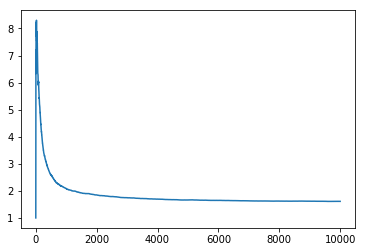

In [3]:
import matplotlib.pyplot as plt
plt.plot(store_lag[0])
plt.show()

In [ ]:
print(store_lag[0][EPISODES-1])

In [4]:
np.savetxt('GWIndependent_penalty',store_penalty)
np.savetxt('GWIndependent_Lag',store_lag)